In [31]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        low = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -2, -2, -0.04, -2.828, -70.71], dtype=np.float32)
        high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2.828, 2.828, 70.71], dtype=np.float32)

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)
        # if self.theta < math.pi:
        #     self.missile_angle = np.random.uniform(0, math.pi)
        # else:
        #     self.missile_angle = np.random.uniform(math.pi, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):

        # check if out of bounds
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

        self.missile_distance_to_attack()
        if self.distance < 0:
            self.reward = 1000
            self.done = True
            self.interceptions += 1
        else:
            self.distance_change = ((self.distance - self.distance_t_minus_one) / 0.02) 
            if self.distance_change < 0:
                self.reward = -1 * (self.distance_change * (0.01 + 1/self.distance))
            else:
                self.reward = -5 * (self.distance_change * 1 + 1 * (self.distance**2))

            # angle penalty
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            if self.angle_diff < 0.05:
                self.reward += 0.1
            else:
                self.reward -= (0.1 * self.angle_diff)

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()
        self.state = np.array([self.attack[0], self.attack[1], self.defense[0], self.defense[1], self.sin_theta, self.cos_theta, self.sin_missile_angle, self.cos_missile_angle, self.delta_sin, self.delta_cos, self.distance, (self.distance - self.distance_t_minus_one), ((self.distance - self.distance_t_minus_one) / 0.02)])

    def get_state_dict(self):
        return {"reward": self.reward, "attack_x": self.attack[0], "attack_y": self.attack[1], "defense_x": self.defense[0], "defense_y": self.defense[1], "theta": self.theta, "missile_angle": self.missile_angle, "self.sin_theta": self.sin_theta, "self.cos_theta": self.cos_theta, "self.sin_missile_angle": self.sin_missile_angle, "self.cos_missile_angle": self.cos_missile_angle, "delta_sin": self.delta_sin, "delta_cos": self.delta_cos, "distance": self.distance}
                 
    def step(self, action):
        if self.current_step >= self.max_steps_per_episode:
            self.done = True
            self.reward = -100
            self.reached_max_steps += 1

        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calculate_reward()
        self.current_step += 1
        self.get_state()

        # self.graph(self.defense, self.attack)

        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()

In [33]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

def run_episode(env, model):
    # If you have only one environment wrapped, you can directly access it
    single_env = env.envs[0]
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        step += 1
    
    # Now access the specific attributes from the single_env which is your actual missile_interception instance
    return step, total_reward, single_env.out_of_bounds, single_env.interceptions, single_env.reached_max_steps



# Create the environment
env = make_vec_env(lambda: missile_interception(), n_envs=1)

# Create the model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_missile_interception_logs_v2")

# Create a summary writer
summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs_v2/custom_metrics')

# Training loop
total_timesteps = 1000000
eval_interval = 10000  # Evaluate and log every 10000 steps

for step in range(0, total_timesteps, eval_interval):
    # Train for a number of timesteps
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Run an evaluation episode
    episode_length, episode_reward, out_of_bounds, interceptions, reached_max_steps = run_episode(env, model)
    
    # Log the results
    with summary_writer.as_default():
        tf.summary.scalar('Evaluation/Episode Length', episode_length, step=step)
        # Ensure episode_reward and other metrics are scalars by using .item() if they are numpy arrays or tensors
        tf.summary.scalar('Evaluation/Episode Reward', episode_reward.item() if isinstance(episode_reward, np.ndarray) else episode_reward, step=step)
        tf.summary.scalar('Evaluation/Out of Bounds Count', out_of_bounds.item() if isinstance(out_of_bounds, np.ndarray) else out_of_bounds, step=step)
        tf.summary.scalar('Evaluation/Interceptions Count', interceptions.item() if isinstance(interceptions, np.ndarray) else interceptions, step=step)
        tf.summary.scalar('Evaluation/Reached Max Steps Count', reached_max_steps.item() if isinstance(reached_max_steps, np.ndarray) else reached_max_steps, step=step)
        summary_writer.flush()


# Save the final model
model.save("dqn_missile_interception")

Using cpu device
Logging to ./dqn_missile_interception_logs_v2\DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 69.5     |
|    ep_rew_mean      | -370     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2089     |
|    time_elapsed     | 0        |
|    total_timesteps  | 278      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.44     |
|    n_updates        | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81.9     |
|    ep_rew_mean      | -478     |
|    exploration_rate | 0.378    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1889     |
|    time_elapsed     | 0        |
|    total_timesteps  | 655      |
| train/              |          |
|    learning_rate   

DEFENSE POSITIONS:  [array([-0.09249907, -0.2578562 ])]
STEP REWARD:  0.7524306249332432
EPISODE REWARD:  0.7524306249332432


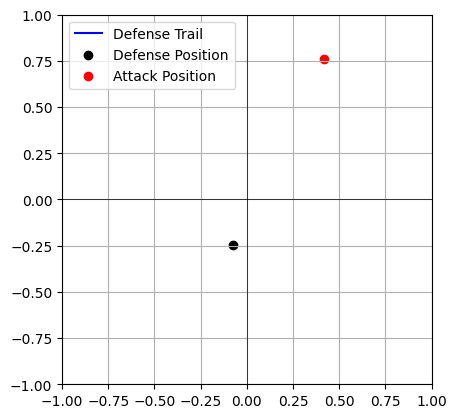

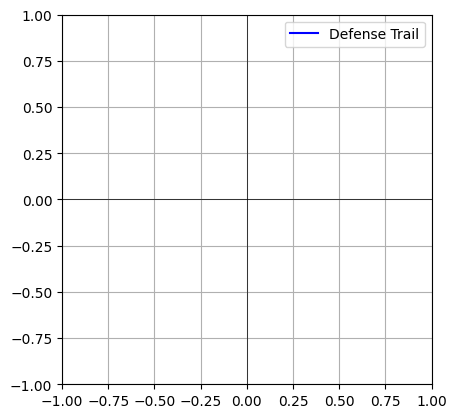

DEFENSE POSITIONS:  [array([-0.07574959, -0.24692665]), array([-0.07574959, -0.24692665])]
STEP REWARD:  0.8526975461036286
EPISODE REWARD:  1.6051281710368719


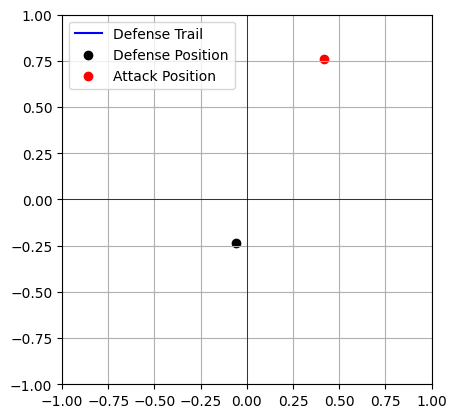

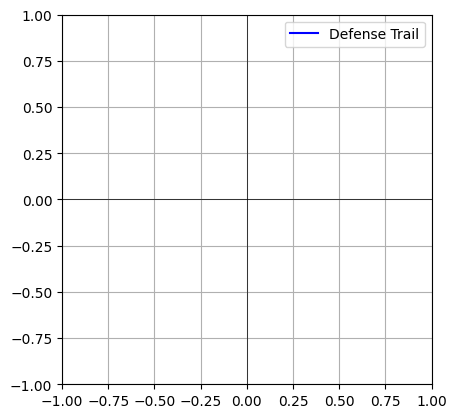

DEFENSE POSITIONS:  [array([-0.06115247, -0.23325463]), array([-0.06115247, -0.23325463]), array([-0.06115247, -0.23325463])]
STEP REWARD:  0.9321694397122285
EPISODE REWARD:  2.5372976107491003


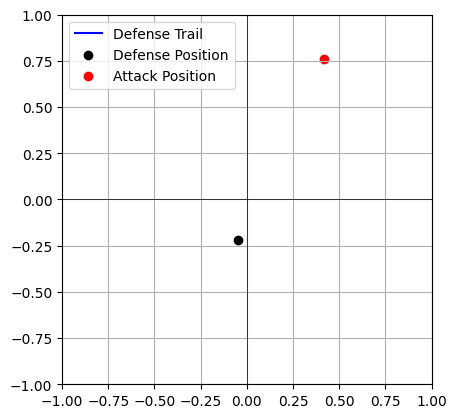

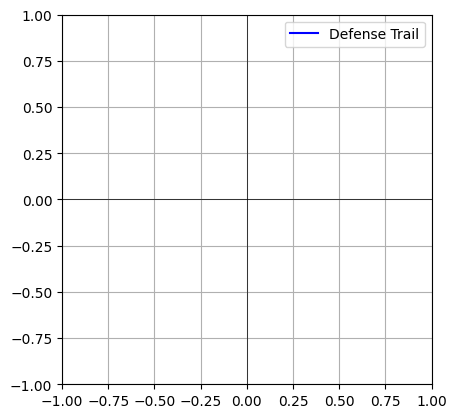

DEFENSE POSITIONS:  [array([-0.04915124, -0.21725556]), array([-0.04915124, -0.21725556]), array([-0.04915124, -0.21725556]), array([-0.04915124, -0.21725556])]
STEP REWARD:  0.9494710540064573
EPISODE REWARD:  3.486768664755558


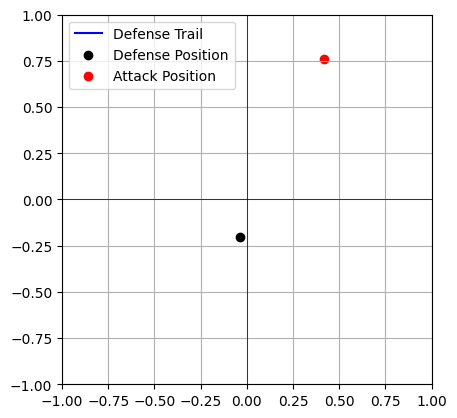

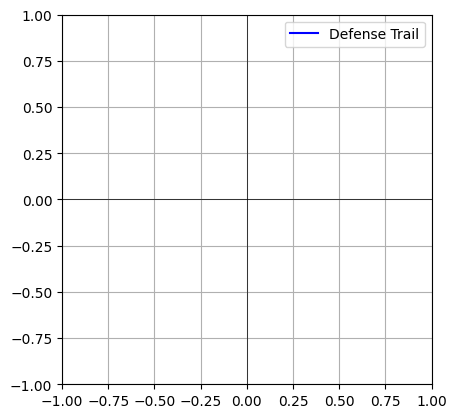

DEFENSE POSITIONS:  [array([-0.03715   , -0.20125648]), array([-0.03715   , -0.20125648]), array([-0.03715   , -0.20125648]), array([-0.03715   , -0.20125648]), array([-0.03715   , -0.20125648])]
STEP REWARD:  0.967393366705711
EPISODE REWARD:  4.454162031461268


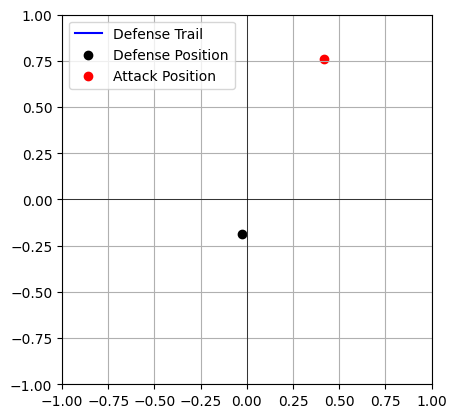

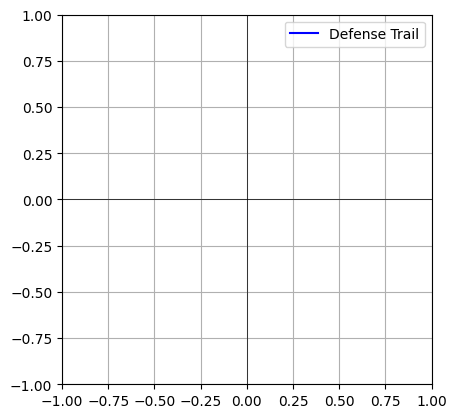

DEFENSE POSITIONS:  [array([-0.02514877, -0.18525741]), array([-0.02514877, -0.18525741]), array([-0.02514877, -0.18525741]), array([-0.02514877, -0.18525741]), array([-0.02514877, -0.18525741]), array([-0.02514877, -0.18525741])]
STEP REWARD:  1.1258348453680087
EPISODE REWARD:  5.579996876829277


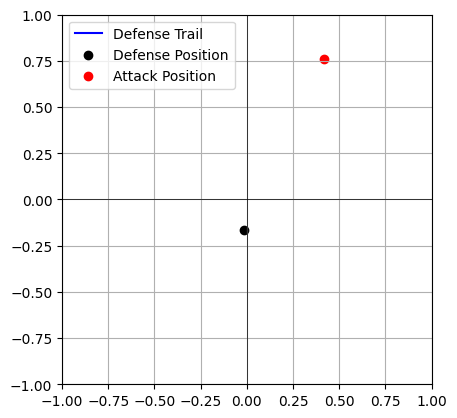

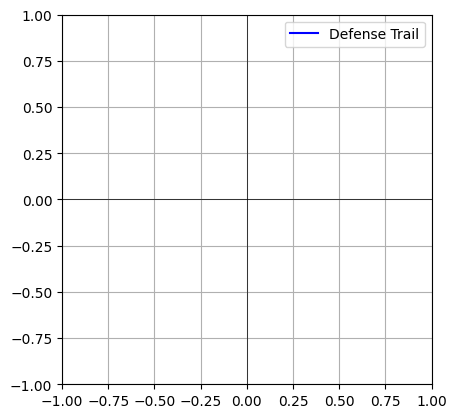

DEFENSE POSITIONS:  [array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ]), array([-0.01610807, -0.1674174 ])]
STEP REWARD:  1.1468804809989261
EPISODE REWARD:  6.7268773578282035


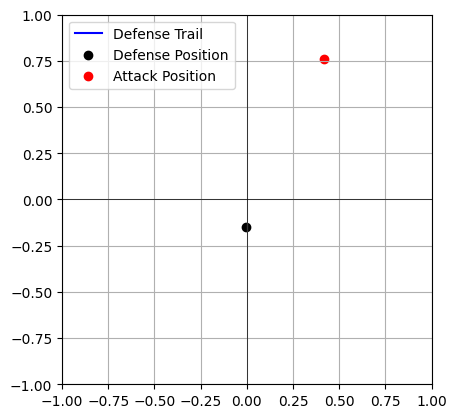

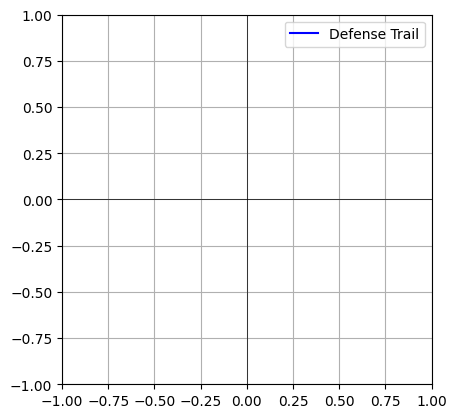

DEFENSE POSITIONS:  [array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ]), array([-0.00706737, -0.1495774 ])]
STEP REWARD:  1.168815740077455
EPISODE REWARD:  7.895693097905658


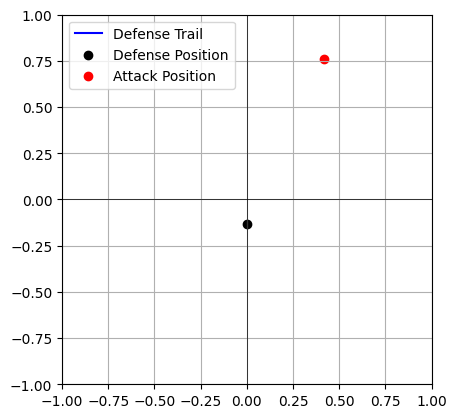

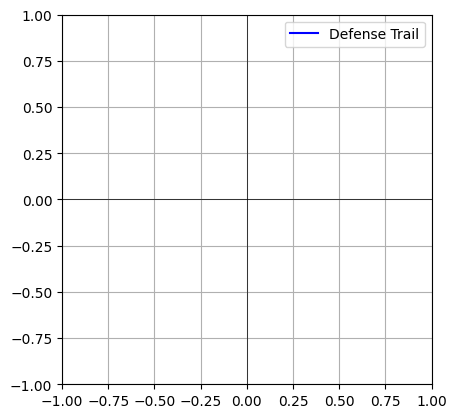

DEFENSE POSITIONS:  [array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739]), array([ 0.00197333, -0.13173739])]
STEP REWARD:  1.191698194857521
EPISODE REWARD:  9.08739129276318


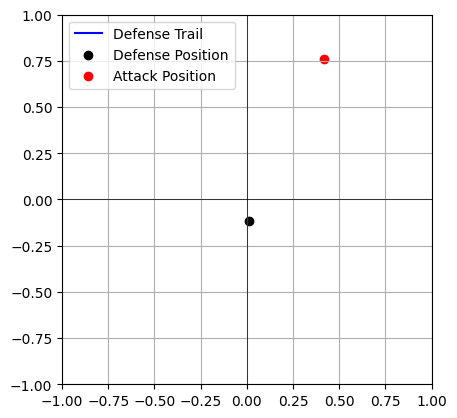

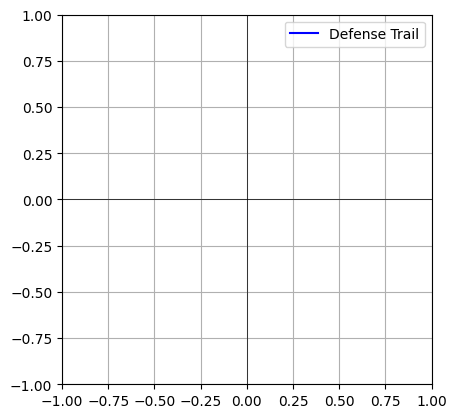

DEFENSE POSITIONS:  [array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739]), array([ 0.01101403, -0.11389739])]
STEP REWARD:  1.215590490237022
EPISODE REWARD:  10.3029817830002


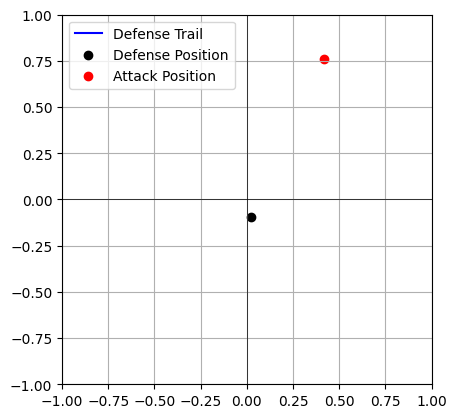

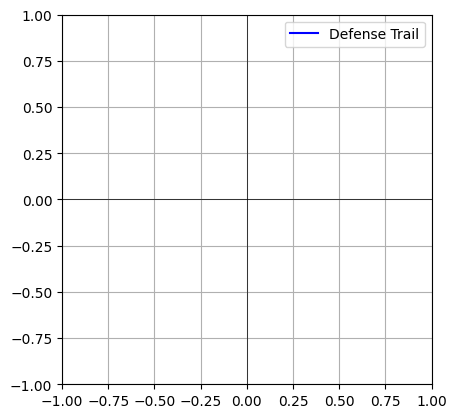

DEFENSE POSITIONS:  [array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738]), array([ 0.02005472, -0.09605738])]
STEP REWARD:  1.2405609145170176
EPISODE REWARD:  11.543542697517218


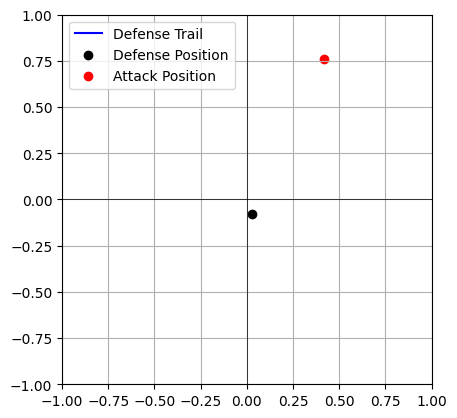

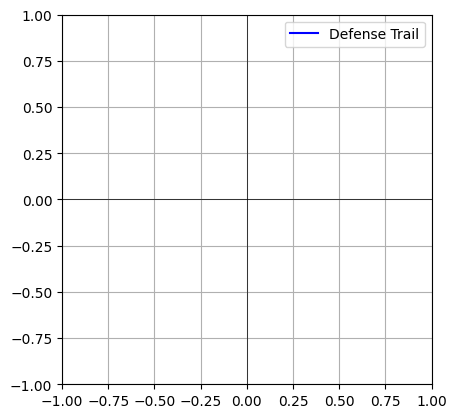

DEFENSE POSITIONS:  [array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738]), array([ 0.02909542, -0.07821738])]
STEP REWARD:  1.266684048930781
EPISODE REWARD:  12.810226746447999


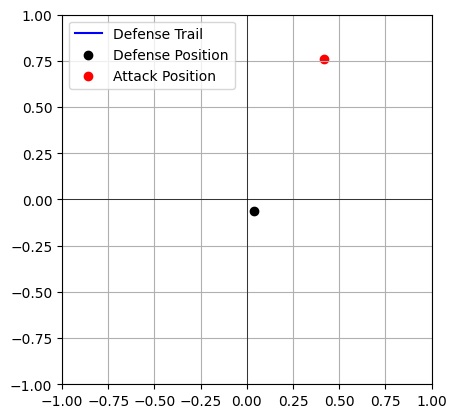

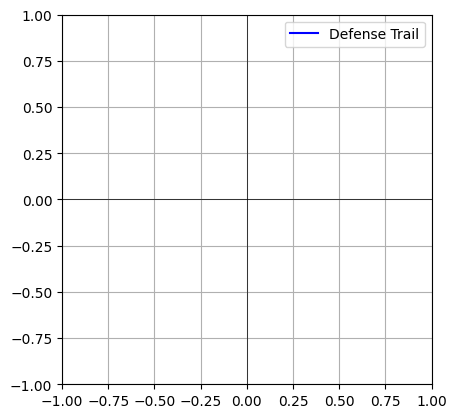

DEFENSE POSITIONS:  [array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738]), array([ 0.03813612, -0.06037738])]
STEP REWARD:  1.294041508913121
EPISODE REWARD:  14.10426825536112


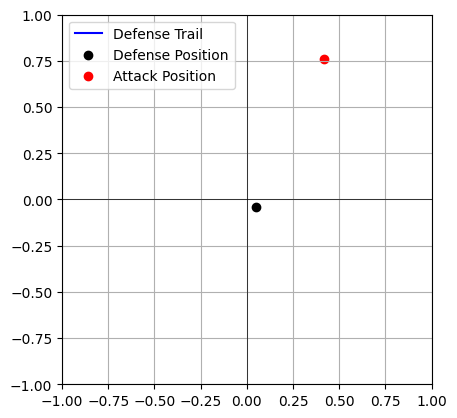

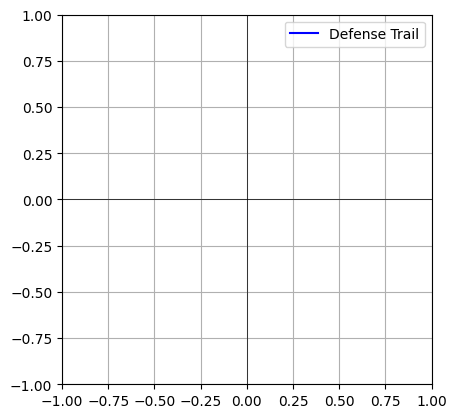

DEFENSE POSITIONS:  [array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737]), array([ 0.04717682, -0.04253737])]
STEP REWARD:  1.322722792578098
EPISODE REWARD:  15.426991047939218


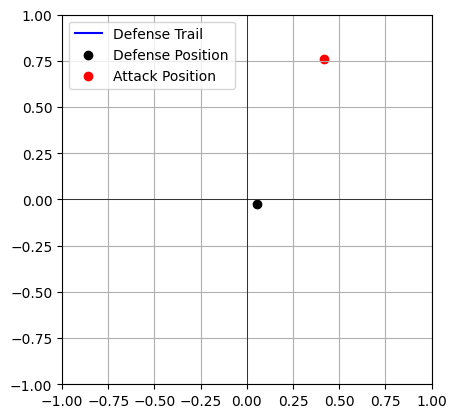

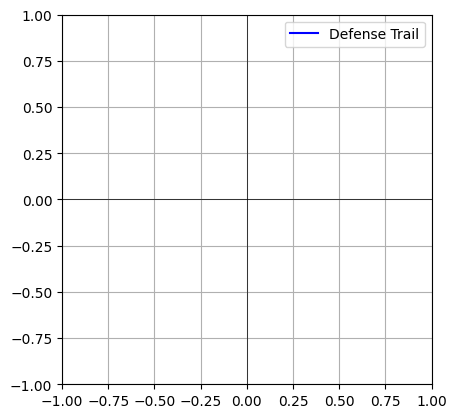

DEFENSE POSITIONS:  [array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737]), array([ 0.05621752, -0.02469737])]
STEP REWARD:  1.3528262549242496
EPISODE REWARD:  16.779817302863467


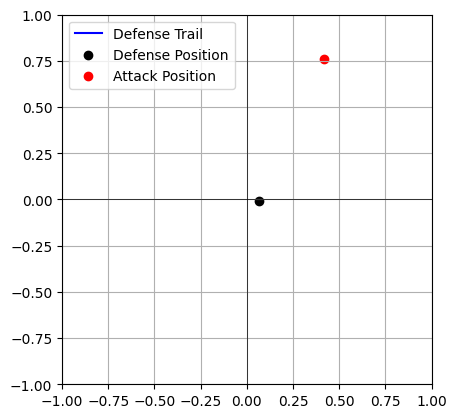

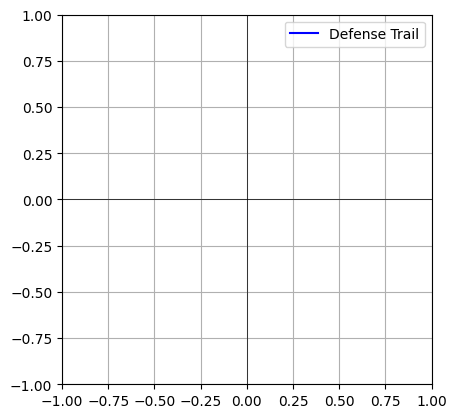

DEFENSE POSITIONS:  [array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736]), array([ 0.06525822, -0.00685736])]
STEP REWARD:  1.3844602300323308
EPISODE REWARD:  18.1642775328958


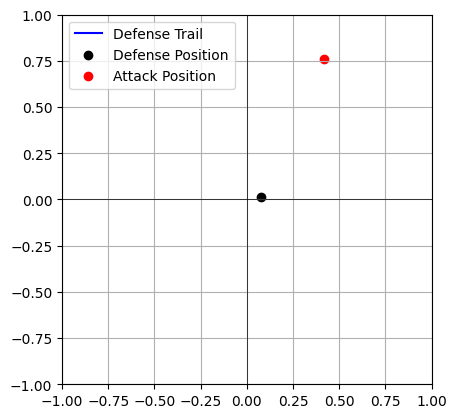

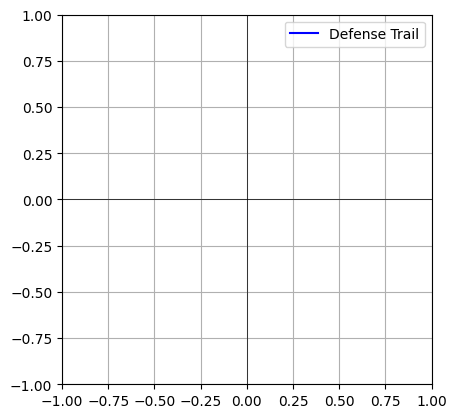

DEFENSE POSITIONS:  [array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264]), array([0.07429892, 0.01098264])]
STEP REWARD:  1.4177443281387847
EPISODE REWARD:  19.582021861034583


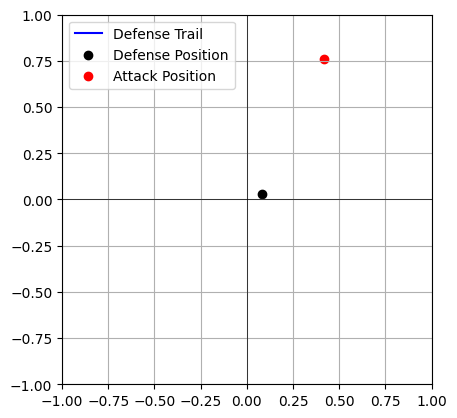

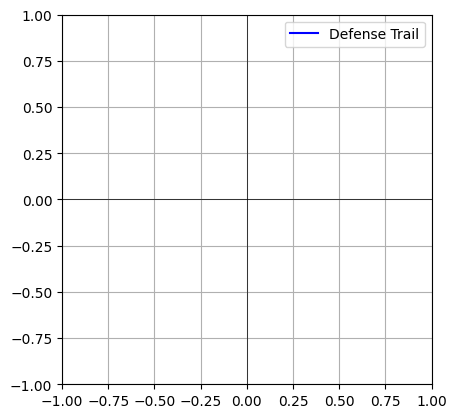

DEFENSE POSITIONS:  [array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265]), array([0.08333962, 0.02882265])]
STEP REWARD:  1.452810940192655
EPISODE REWARD:  21.03483280122724


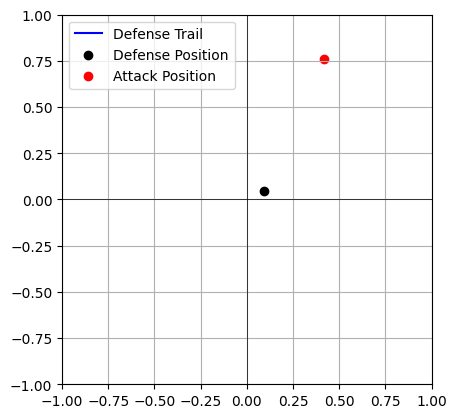

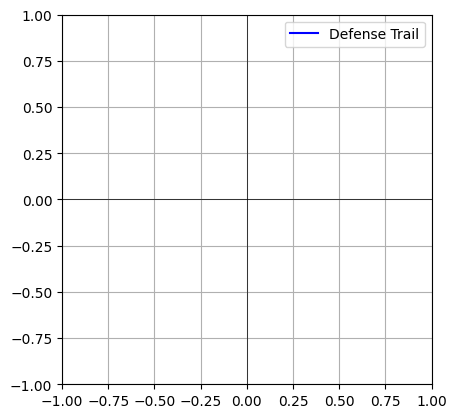

DEFENSE POSITIONS:  [array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265]), array([0.09238031, 0.04666265])]
STEP REWARD:  1.489806989635492
EPISODE REWARD:  22.524639790862732


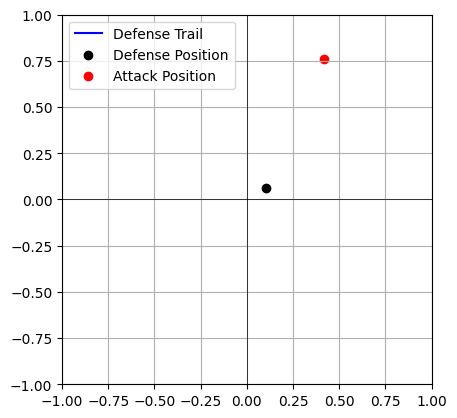

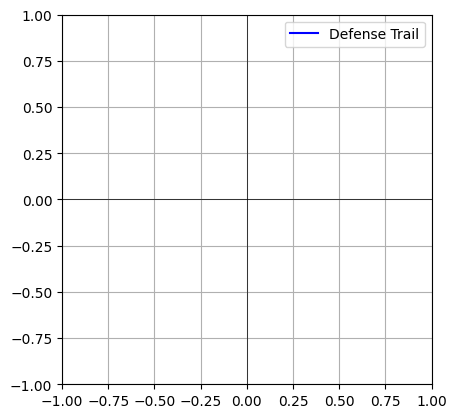

DEFENSE POSITIONS:  [array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266]), array([0.10142101, 0.06450266])]
STEP REWARD:  1.5288959800775905
EPISODE REWARD:  24.05353577094032


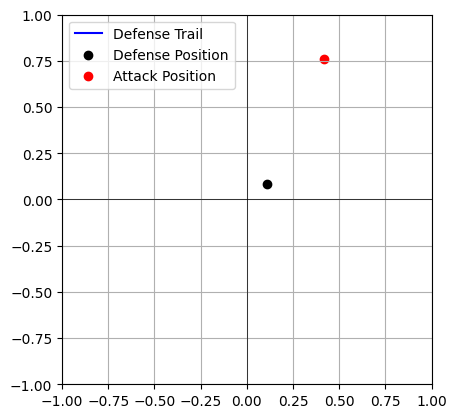

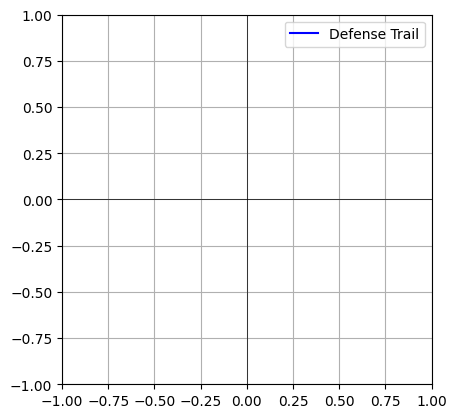

DEFENSE POSITIONS:  [array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266]), array([0.11046171, 0.08234266])]
STEP REWARD:  1.570260398800529
EPISODE REWARD:  25.62379616974085


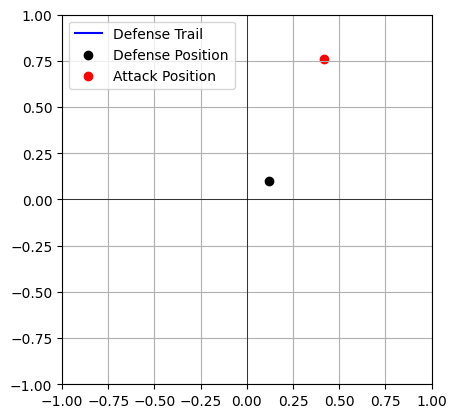

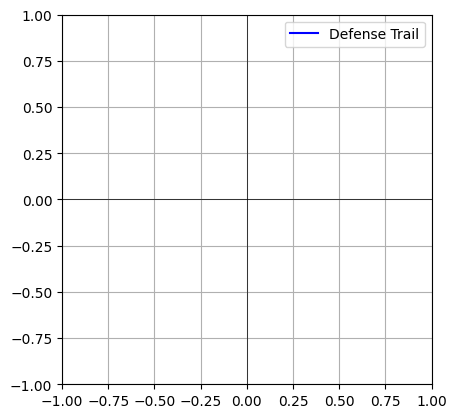

DEFENSE POSITIONS:  [array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267]), array([0.11950241, 0.10018267])]
STEP REWARD:  1.6141045502855333
EPISODE REWARD:  27.23790072002638


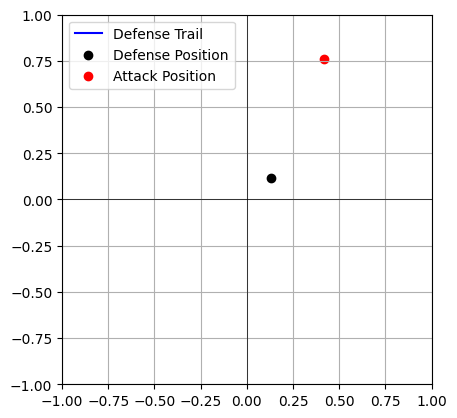

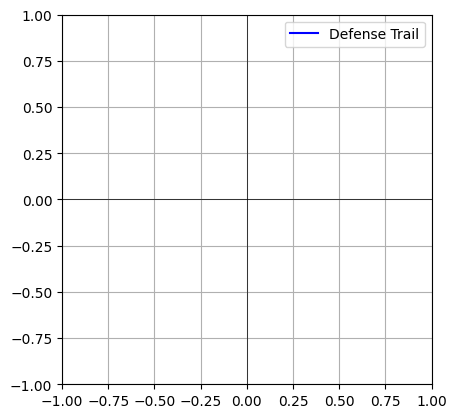

DEFENSE POSITIONS:  [array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267]), array([0.12854311, 0.11802267])]
STEP REWARD:  1.660657912171098
EPISODE REWARD:  28.898558632197478


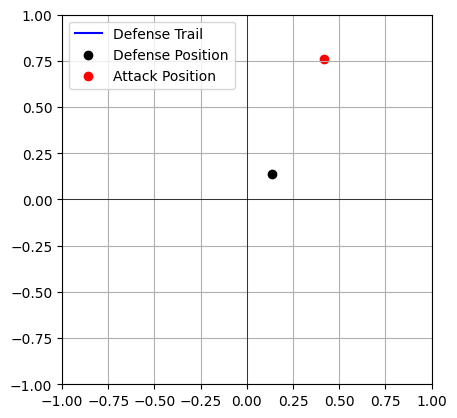

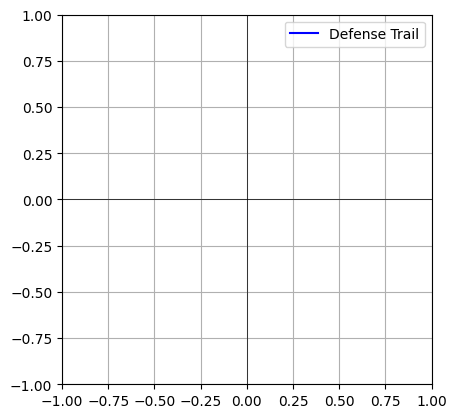

DEFENSE POSITIONS:  [array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268]), array([0.13758381, 0.13586268])]
STEP REWARD:  1.71017912942557
EPISODE REWARD:  30.608737761623047


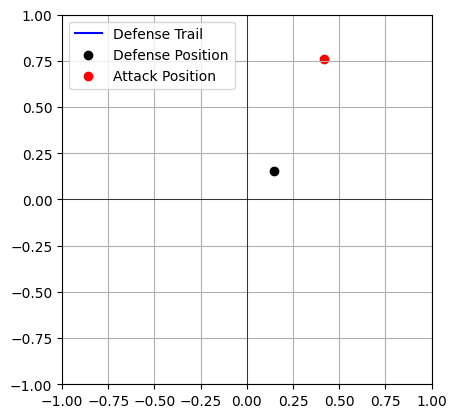

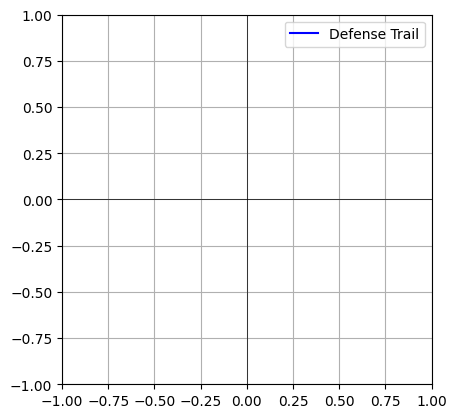

DEFENSE POSITIONS:  [array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268]), array([0.14662451, 0.15370268])]
STEP REWARD:  1.7629607927678674
EPISODE REWARD:  32.37169855439092


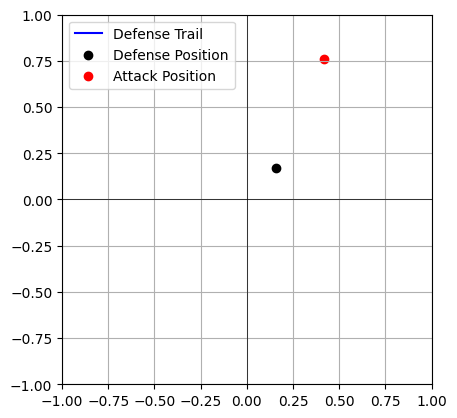

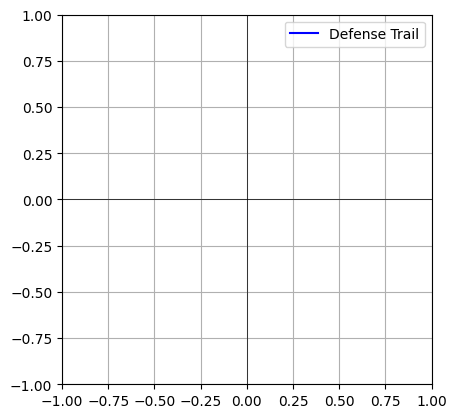

DEFENSE POSITIONS:  [array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269]), array([0.15566521, 0.17154269])]
STEP REWARD:  1.8193351867942886
EPISODE REWARD:  34.19103374118521


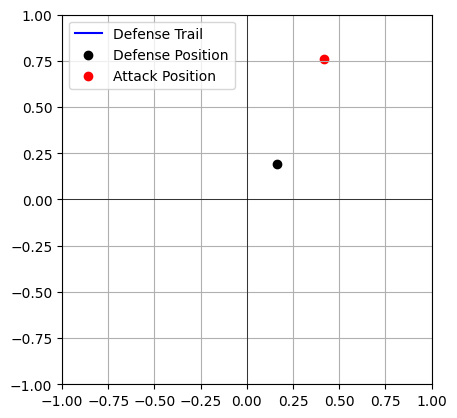

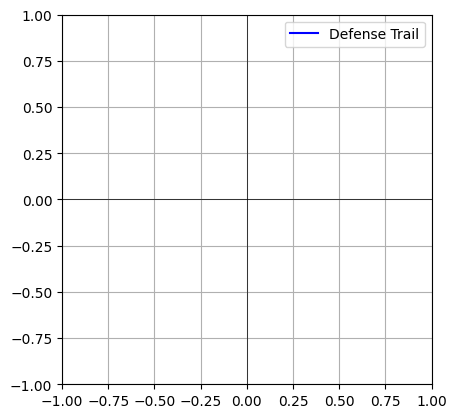

DEFENSE POSITIONS:  [array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269]), array([0.1647059 , 0.18938269])]
STEP REWARD:  1.8796812450718716
EPISODE REWARD:  36.07071498625708


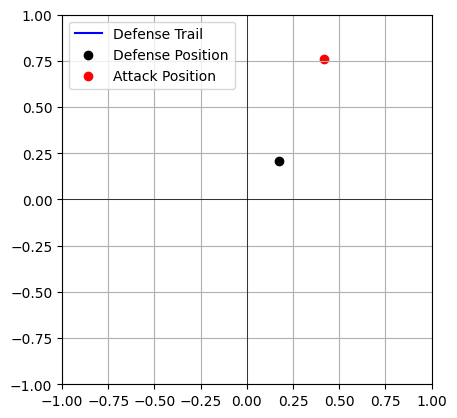

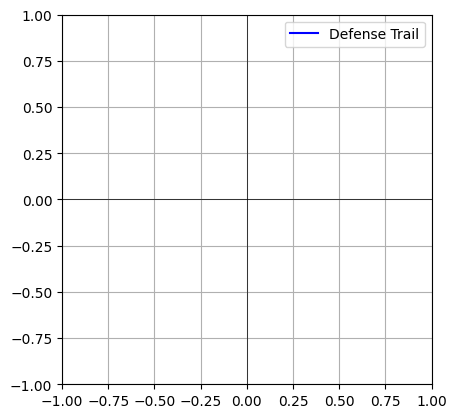

DEFENSE POSITIONS:  [array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269]), array([0.1737466 , 0.20722269])]
STEP REWARD:  1.7780878507663556
EPISODE REWARD:  37.84

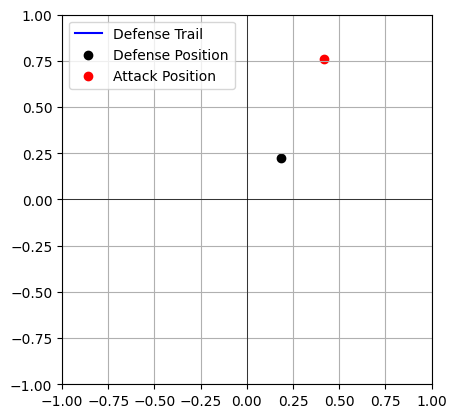

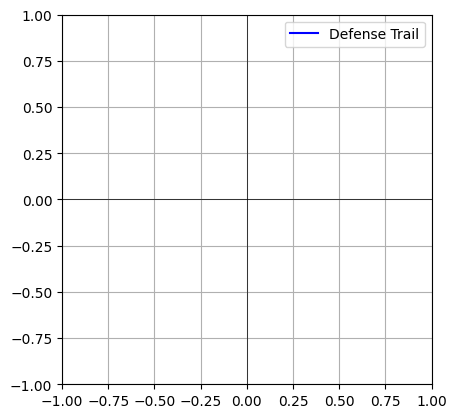

DEFENSE POSITIONS:  [array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177]), array([0.18574784, 0.22322177])]
STEP REWARD:  1.840553

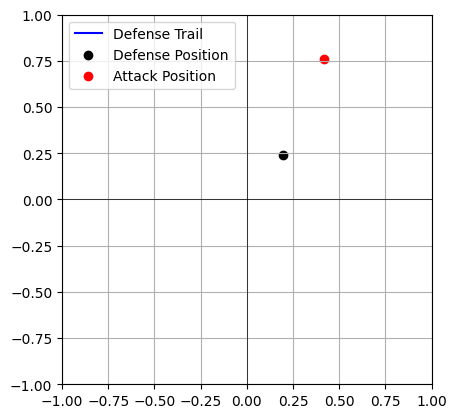

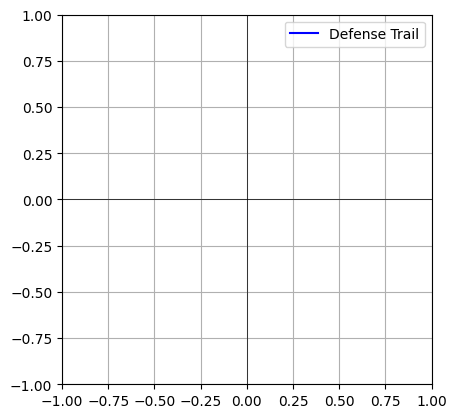

DEFENSE POSITIONS:  [array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.23922084]), array([0.19774907, 0.2

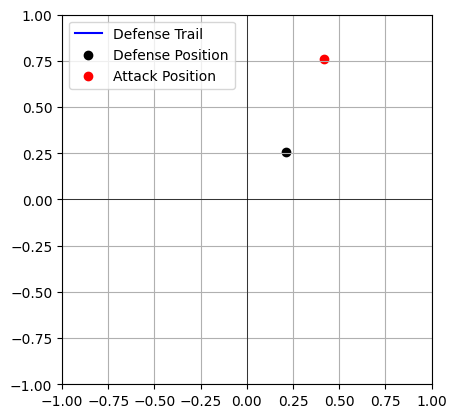

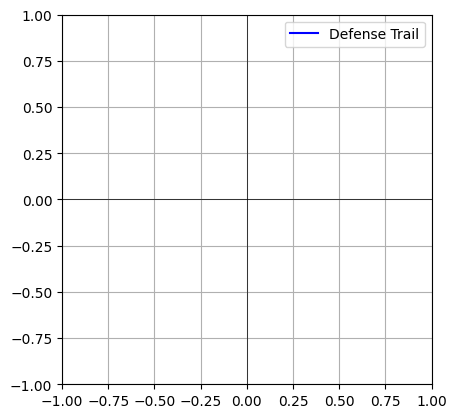

DEFENSE POSITIONS:  [array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.25521992]), array([0.20975031, 0.2

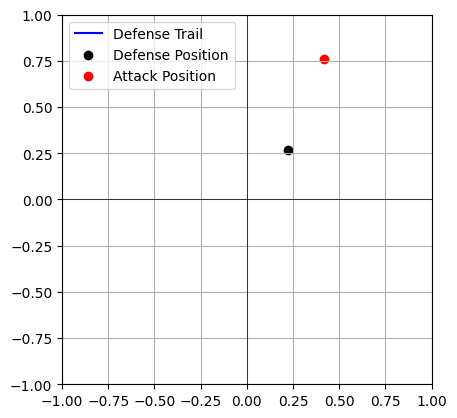

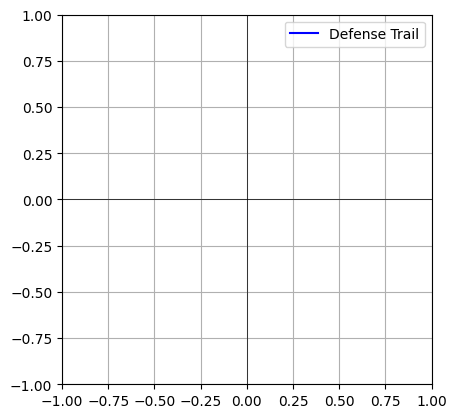

DEFENSE POSITIONS:  [array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.26889194]), array([0.22434742, 0.2

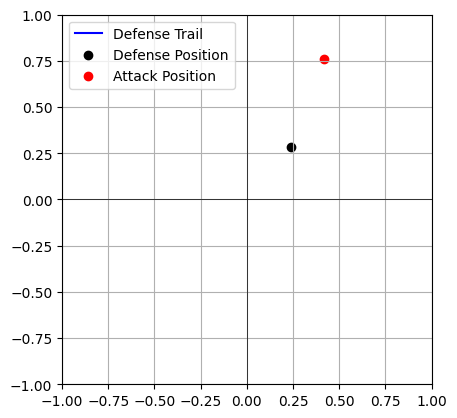

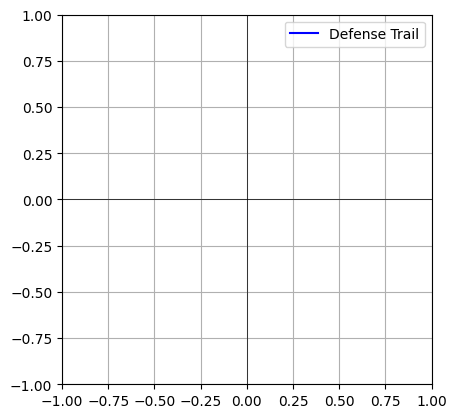

DEFENSE POSITIONS:  [array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.28256396]), array([0.23894454, 0.2

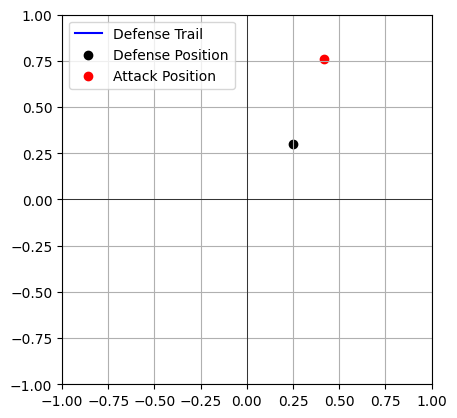

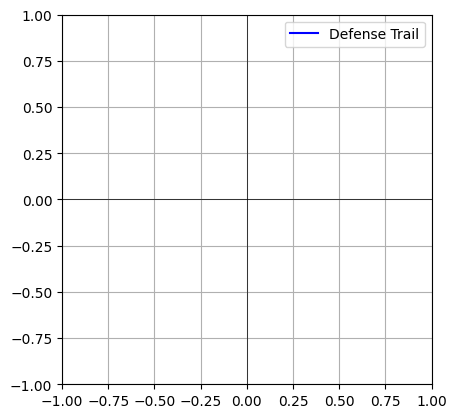

DEFENSE POSITIONS:  [array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.29856303]), array([0.25094578, 0.2

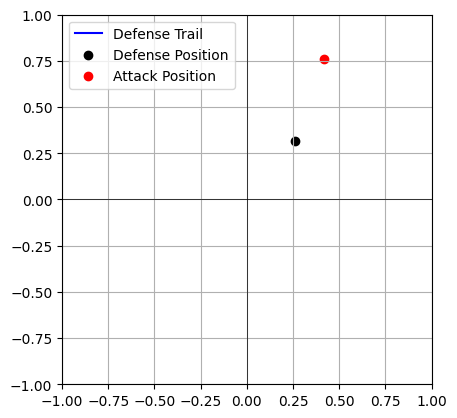

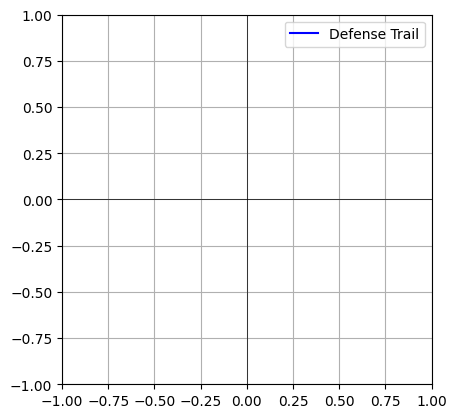

DEFENSE POSITIONS:  [array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.31640304]), array([0.25998648, 0.3

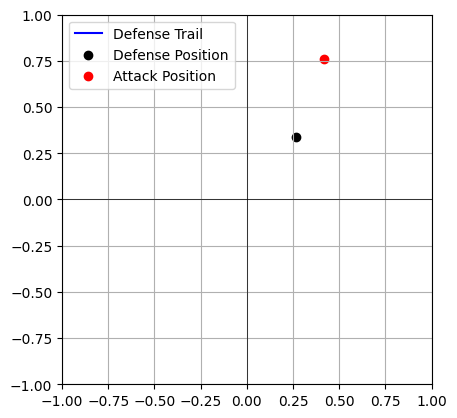

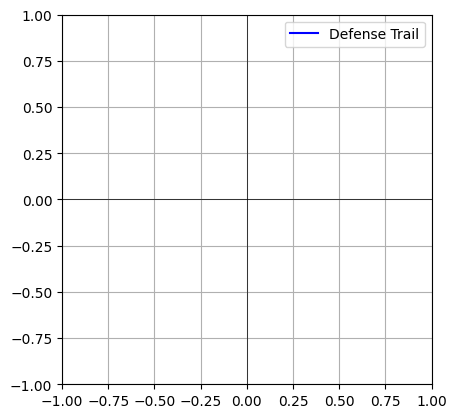

DEFENSE POSITIONS:  [array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.33554191]), array([0.26579194, 0.3

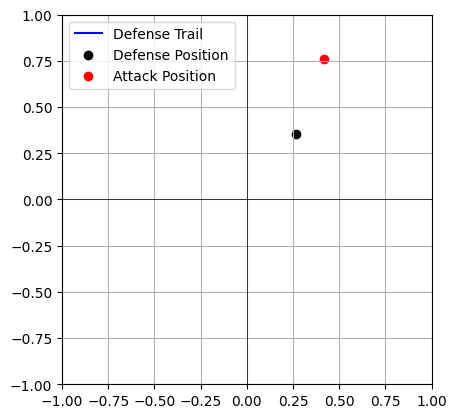

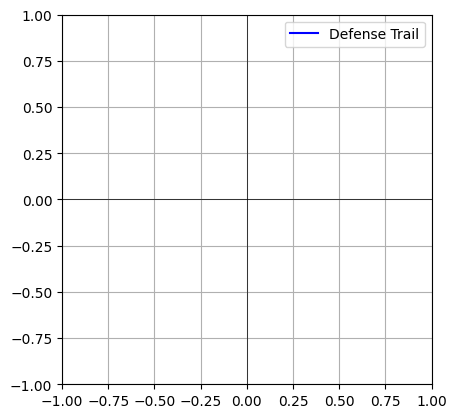

DEFENSE POSITIONS:  [array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.35539813]), array([0.26818578, 0.3

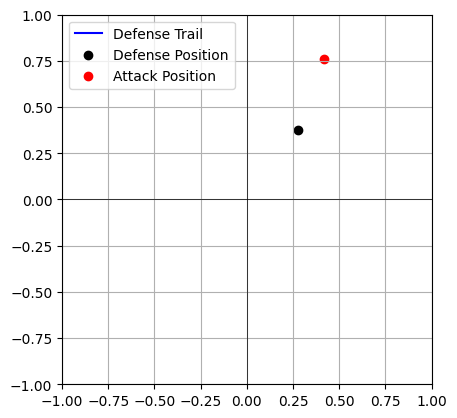

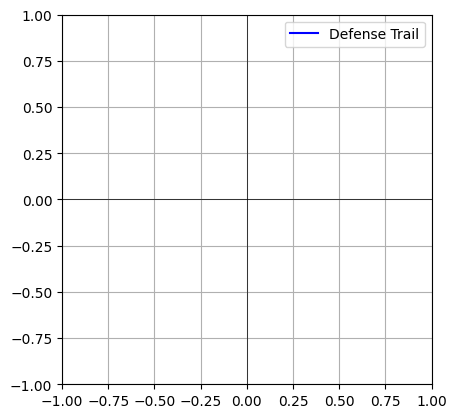

DEFENSE POSITIONS:  [array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.37453701]), array([0.27399125, 0.3

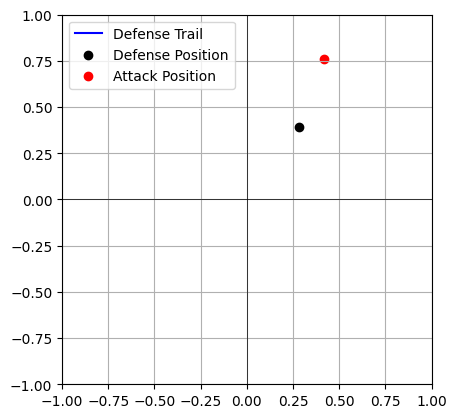

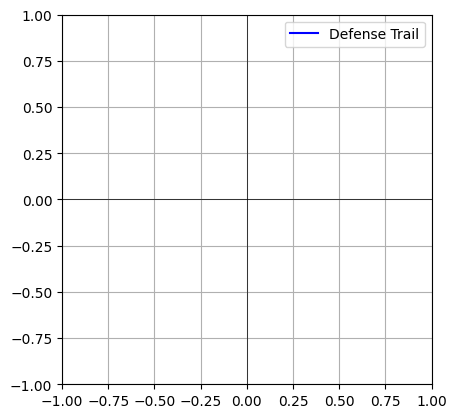

DEFENSE POSITIONS:  [array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.39237701]), array([0.28303194, 0.3

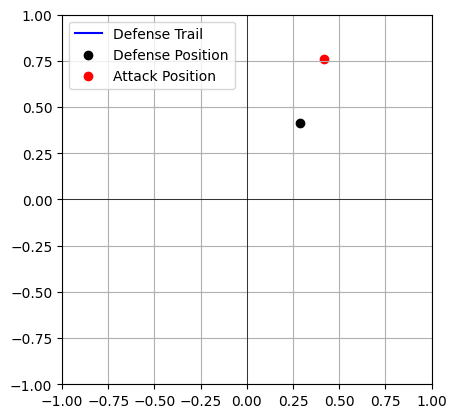

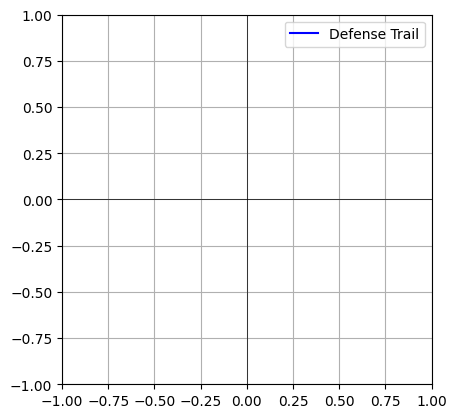

DEFENSE POSITIONS:  [array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.41151589]), array([0.28883741, 0.4

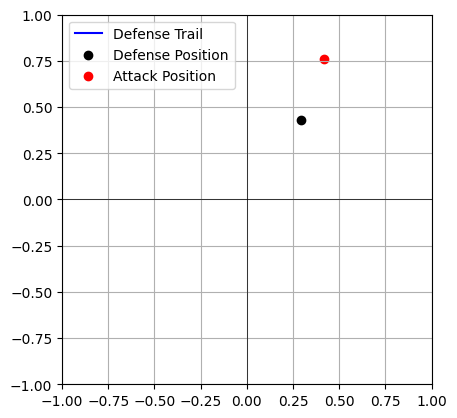

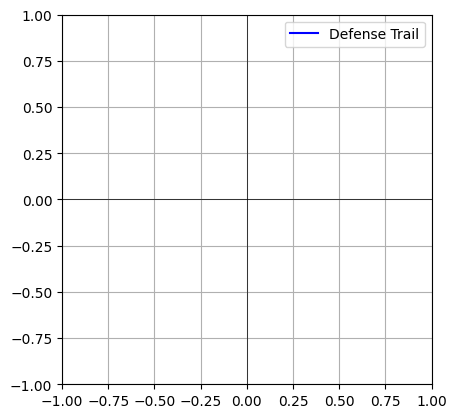

DEFENSE POSITIONS:  [array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.43137211]), array([0.29123125, 0.4

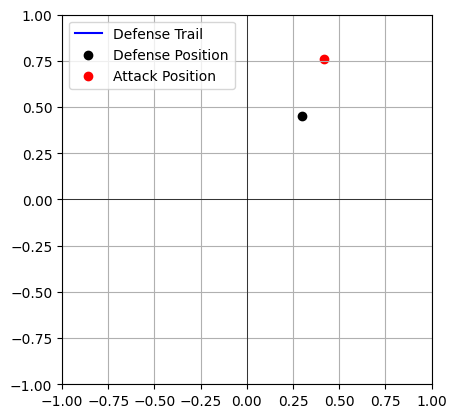

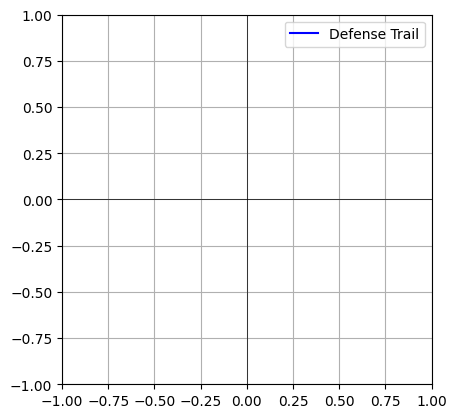

DEFENSE POSITIONS:  [array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.45051099]), array([0.29703671, 0.4

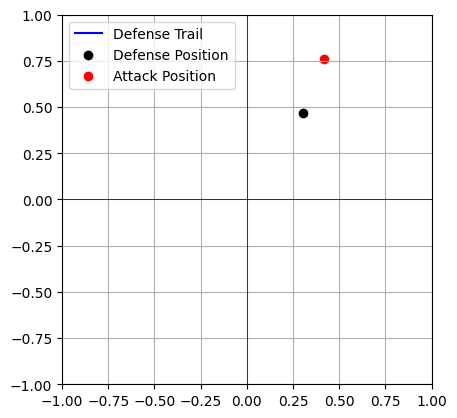

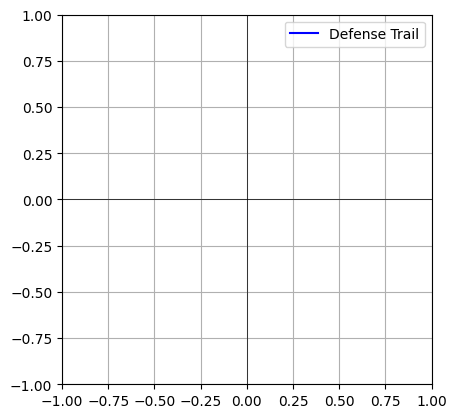

DEFENSE POSITIONS:  [array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.46835099]), array([0.30607741, 0.4

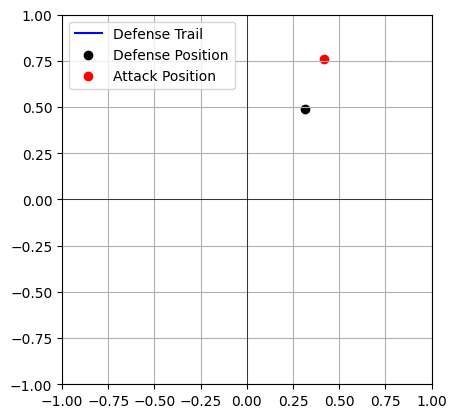

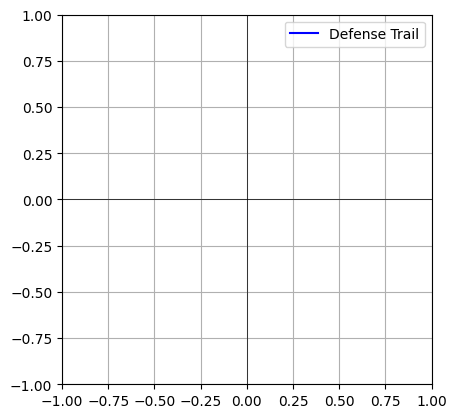

DEFENSE POSITIONS:  [array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.48748987]), array([0.31188288, 0.4

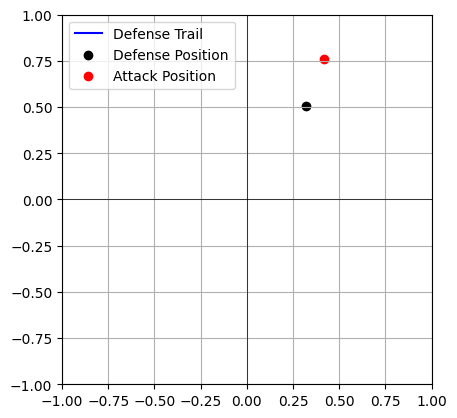

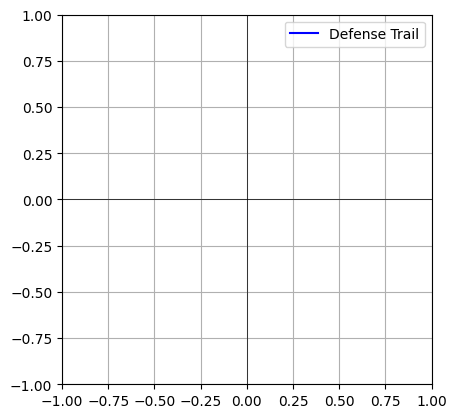

DEFENSE POSITIONS:  [array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.50532987]), array([0.32092358, 0.5

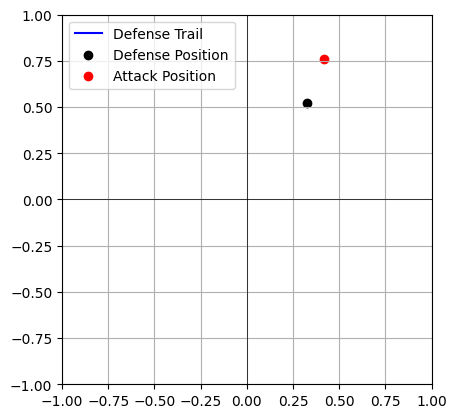

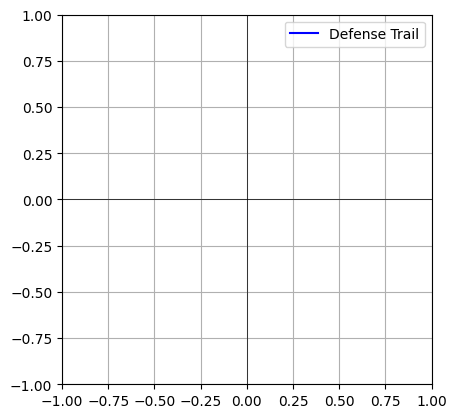

DEFENSE POSITIONS:  [array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.52446875]), array([0.32672904, 0.5

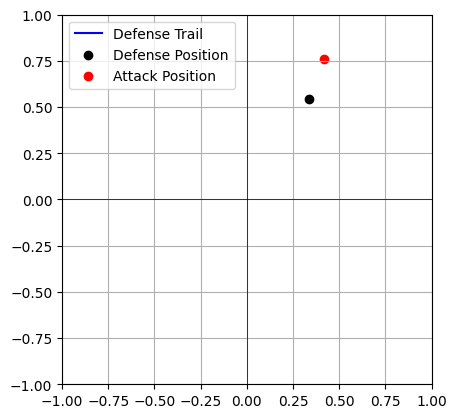

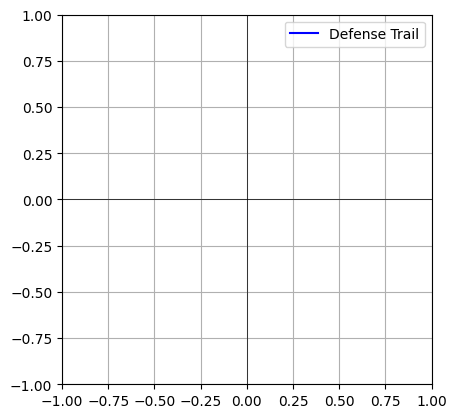

DEFENSE POSITIONS:  [array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.54230875]), array([0.33576974, 0.5

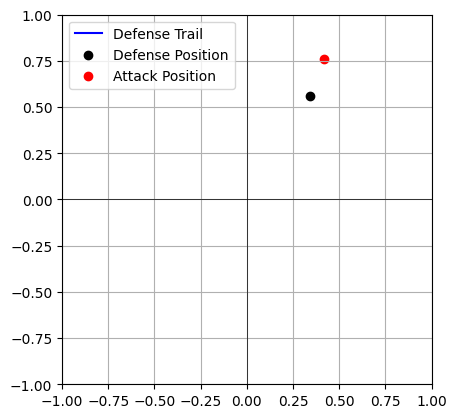

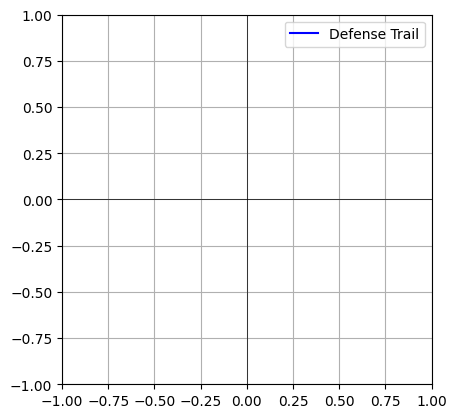

DEFENSE POSITIONS:  [array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.56144763]), array([0.34157521, 0.5

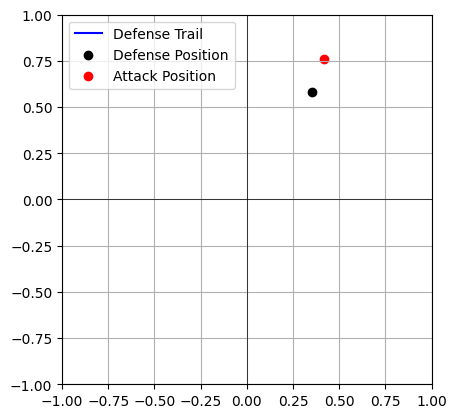

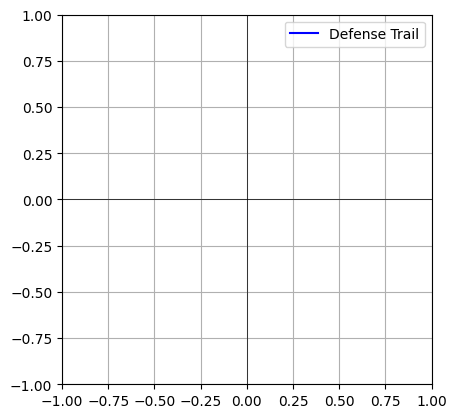

DEFENSE POSITIONS:  [array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.57928763]), array([0.35061591, 0.5

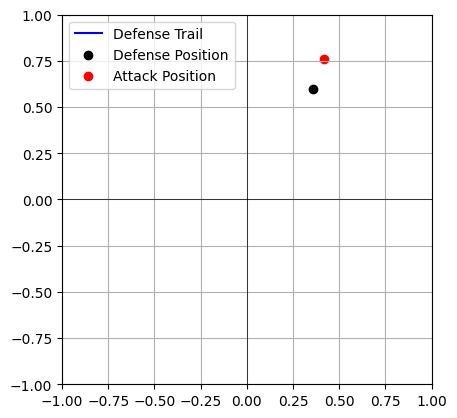

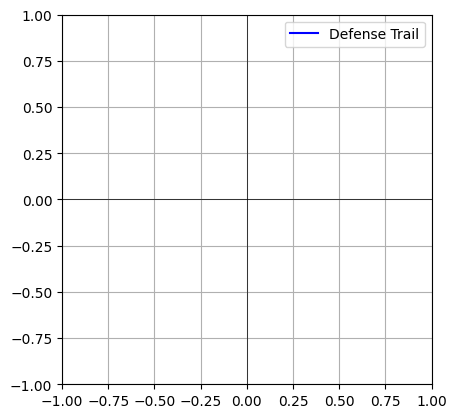

DEFENSE POSITIONS:  [array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.59842651]), array([0.35642137, 0.5

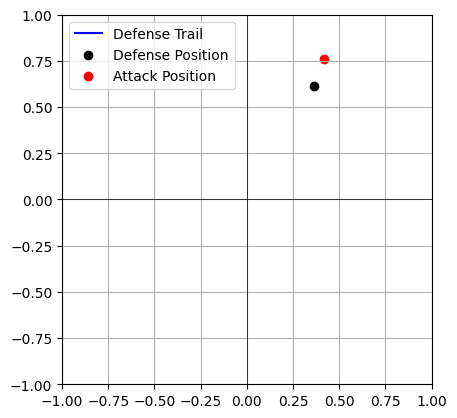

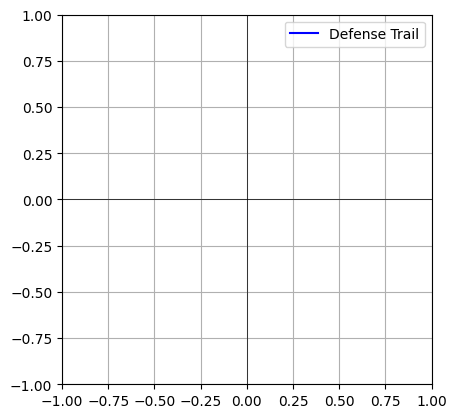

DEFENSE POSITIONS:  [array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.61626651]), array([0.36546207, 0.6

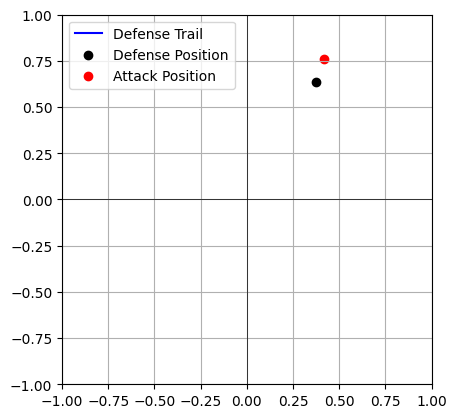

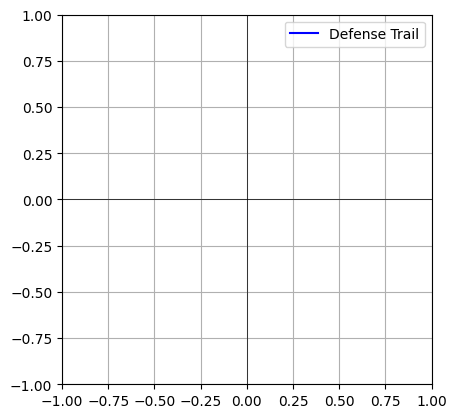

DEFENSE POSITIONS:  [array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.63540539]), array([0.37126754, 0.6

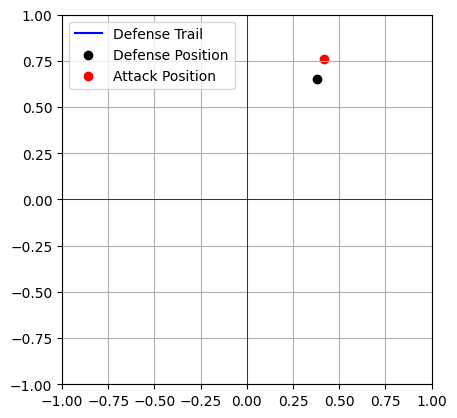

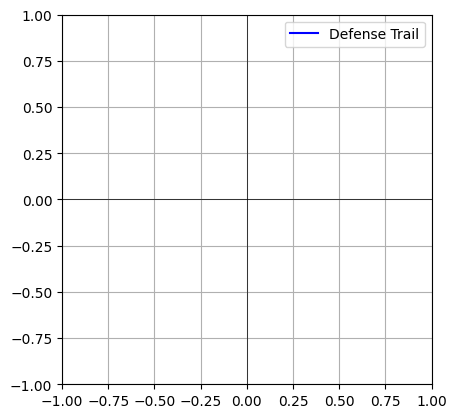

DEFENSE POSITIONS:  [array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.65324539]), array([0.38030823, 0.6

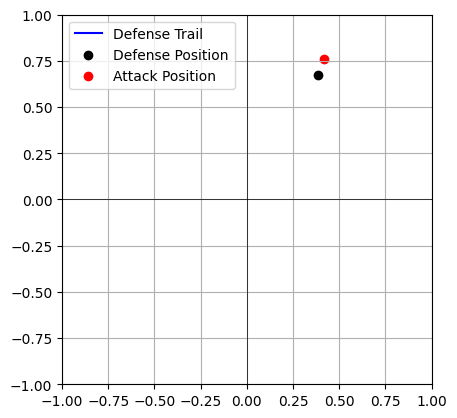

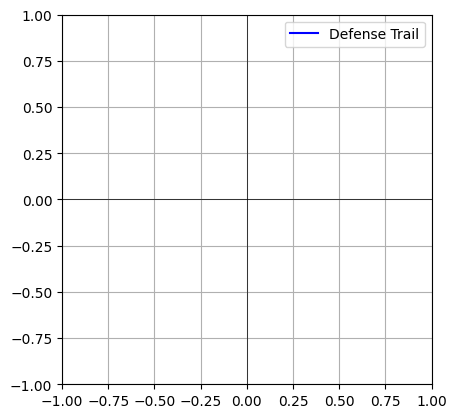

DEFENSE POSITIONS:  [array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.67238427]), array([0.3861137 , 0.6

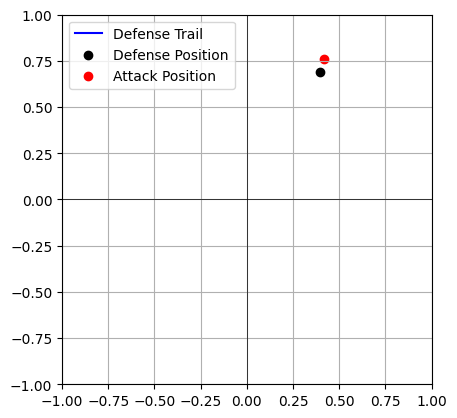

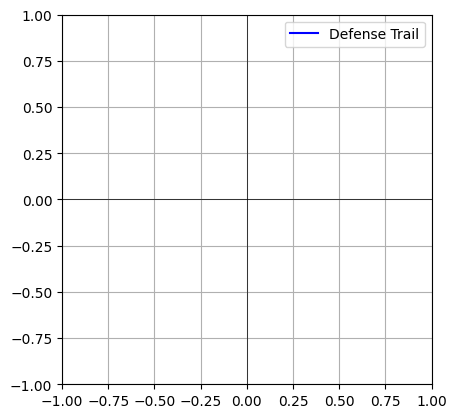

DEFENSE POSITIONS:  [array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.69022427]), array([0.3951544 , 0.6

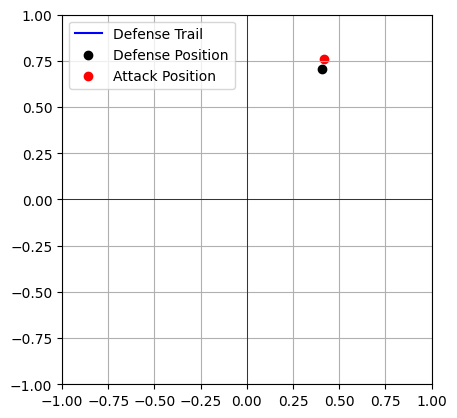

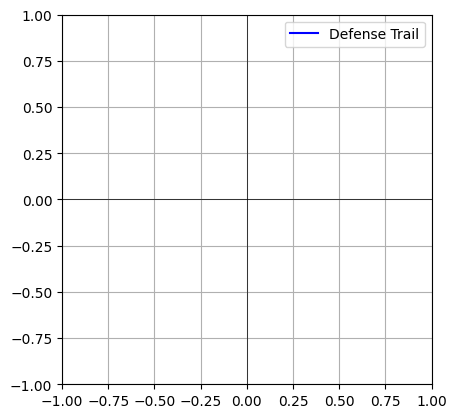

DEFENSE POSITIONS:  [array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.70622335]), array([0.40715563, 0.7

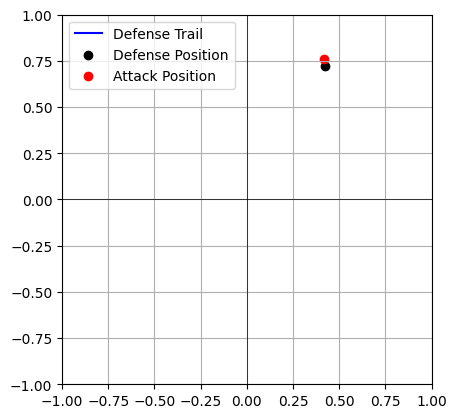

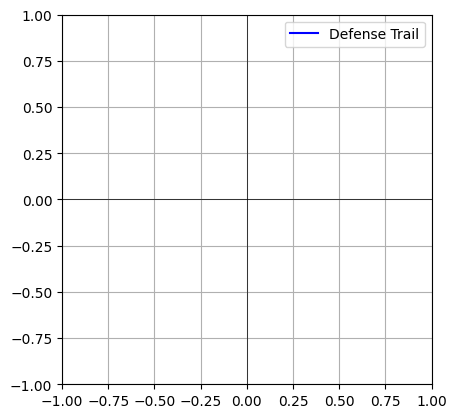

DEFENSE POSITIONS:  [array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.71989537]), array([0.42175275, 0.7

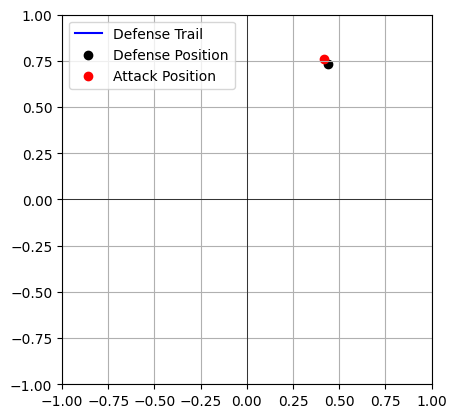

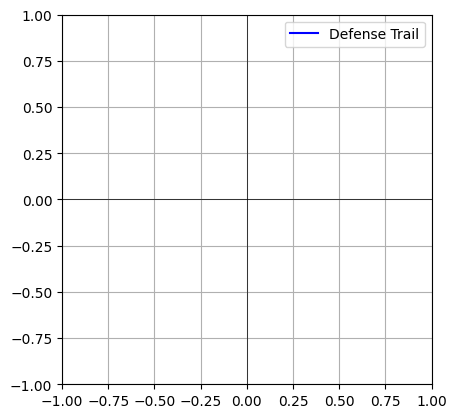

DEFENSE POSITIONS:  [array([-0.21917948,  0.04624531])]
STEP REWARD:  -4.71445301821095
EPISODE REWARD:  -4.71445301821095


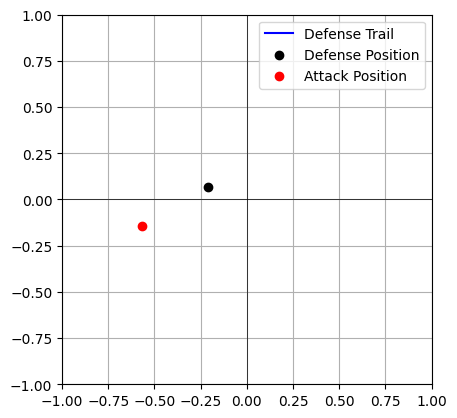

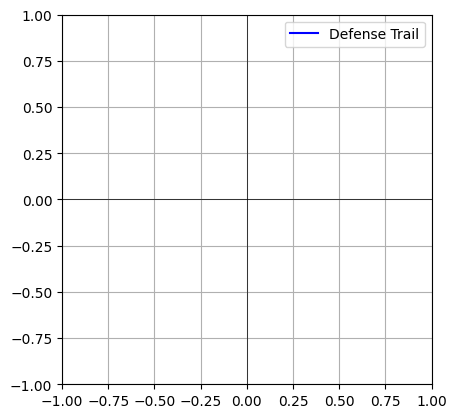

DEFENSE POSITIONS:  [array([-0.21233988,  0.06503945]), array([-0.21233988,  0.06503945])]
STEP REWARD:  -4.253013967062701
EPISODE REWARD:  -8.967466985273651


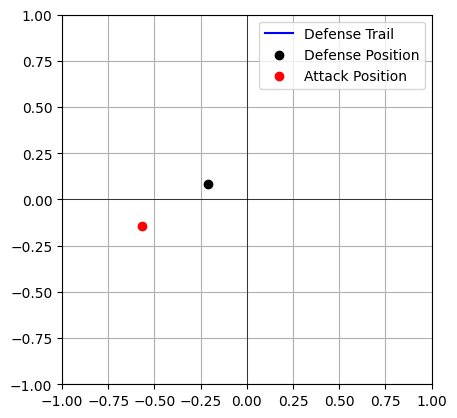

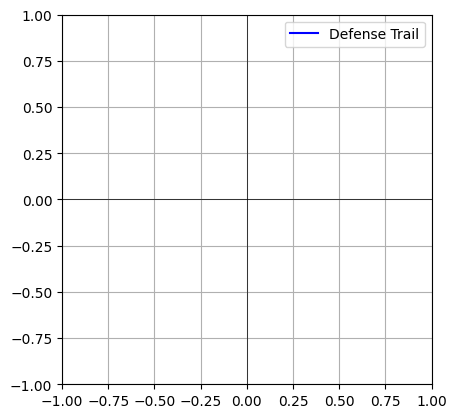

DEFENSE POSITIONS:  [array([-0.20886776,  0.08473575]), array([-0.20886776,  0.08473575]), array([-0.20886776,  0.08473575])]
STEP REWARD:  -3.733577438676671
EPISODE REWARD:  -12.701044423950322


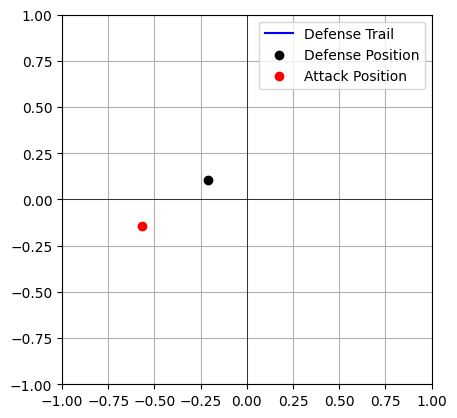

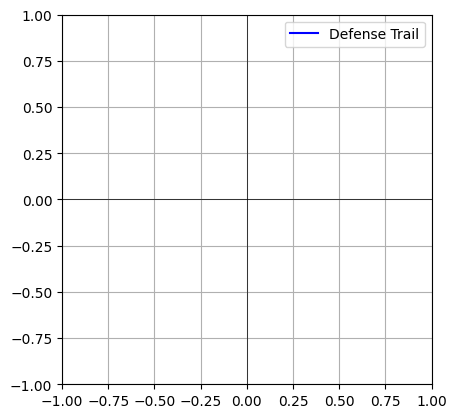

DEFENSE POSITIONS:  [array([-0.20886861,  0.10473575]), array([-0.20886861,  0.10473575]), array([-0.20886861,  0.10473575]), array([-0.20886861,  0.10473575])]
STEP REWARD:  -3.1655859166379416
EPISODE REWARD:  -15.866630340588262


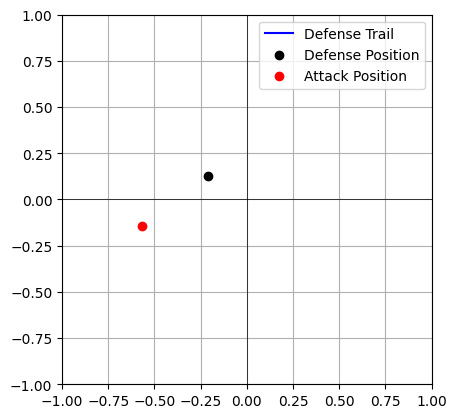

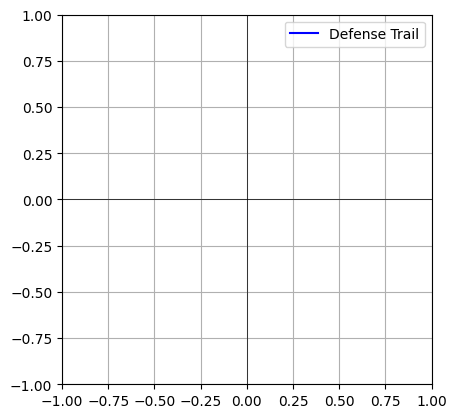

DEFENSE POSITIONS:  [array([-0.21234242,  0.12443176]), array([-0.21234242,  0.12443176]), array([-0.21234242,  0.12443176]), array([-0.21234242,  0.12443176]), array([-0.21234242,  0.12443176])]
STEP REWARD:  -2.5578383743303696
EPISODE REWARD:  -18.424468714918632


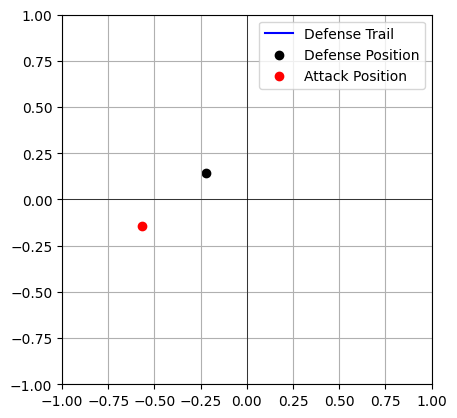

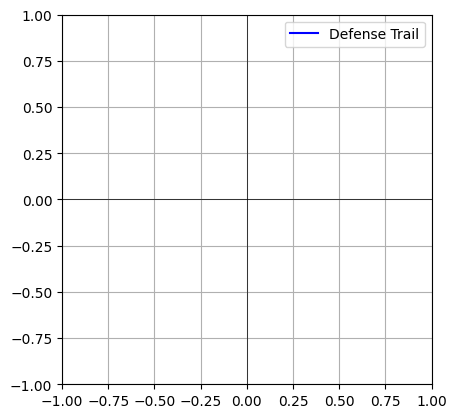

DEFENSE POSITIONS:  [array([-0.21918362,  0.14322532]), array([-0.21918362,  0.14322532]), array([-0.21918362,  0.14322532]), array([-0.21918362,  0.14322532]), array([-0.21918362,  0.14322532]), array([-0.21918362,  0.14322532])]
STEP REWARD:  -1.918824498004816
EPISODE REWARD:  -20.34329321292345


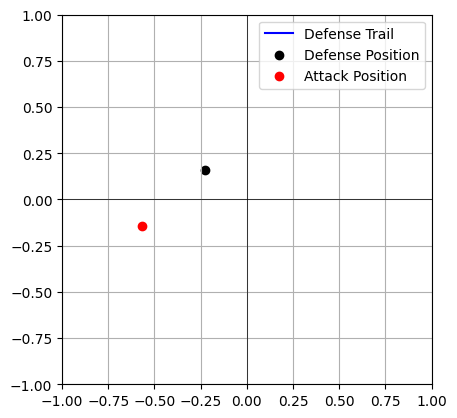

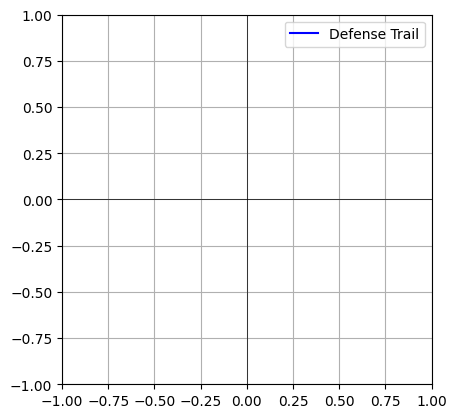

DEFENSE POSITIONS:  [array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ]), array([-0.22918436,  0.1605454 ])]
STEP REWARD:  -1.2569755005226084
EPISODE REWARD:  -21.600268713446056


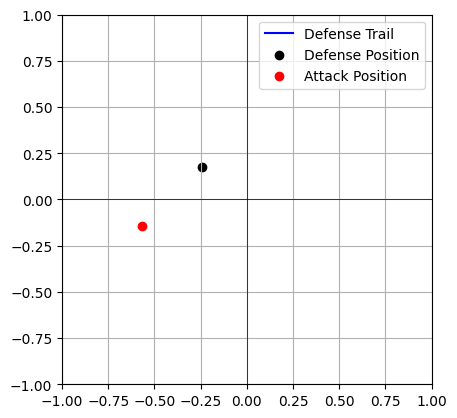

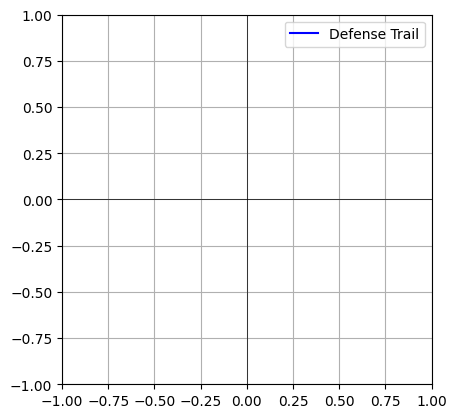

DEFENSE POSITIONS:  [array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574]), array([-0.24204077,  0.17586574])]
STEP REWARD:  0.07026728078208583
EPISODE REWARD:  -21.53000143266397


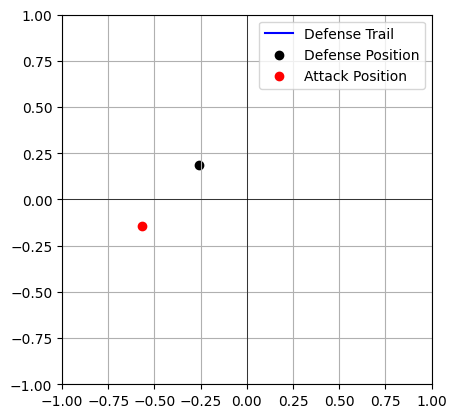

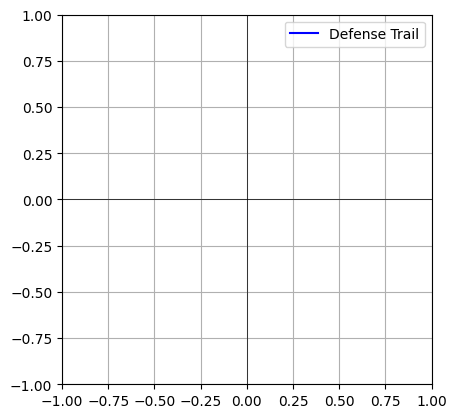

DEFENSE POSITIONS:  [array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084]), array([-0.25736221,  0.18872084])]
STEP REWARD:  0.4078317716114487
EPISODE REWARD:  -21.12216966105252


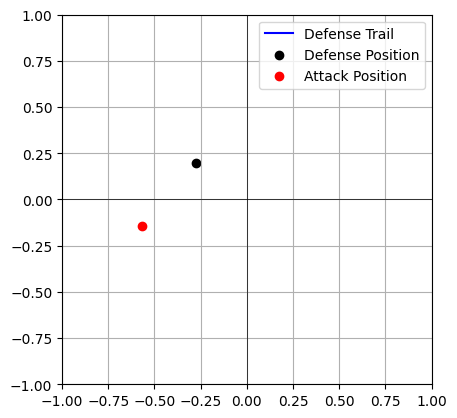

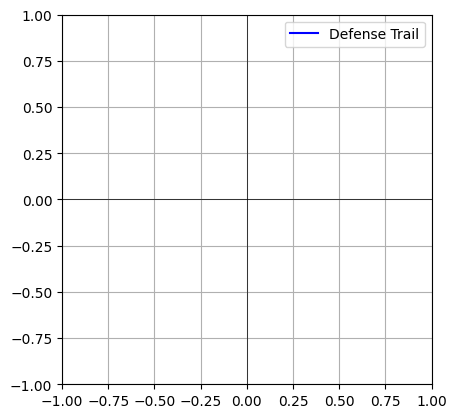

DEFENSE POSITIONS:  [array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ]), array([-0.27468315,  0.1987201 ])]
STEP REWARD:  0.7502406148305663
EPISODE REWARD:  -20.371929046221954


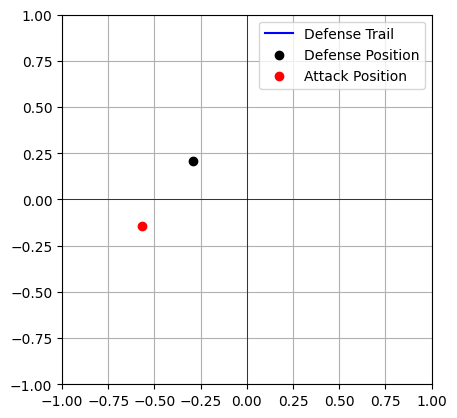

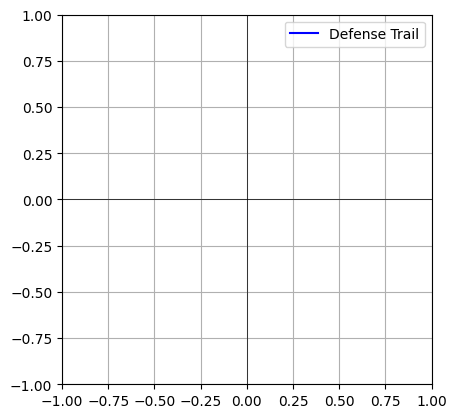

DEFENSE POSITIONS:  [array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ]), array([-0.29347729,  0.2055597 ])]
STEP REWARD:  1.0991487544988159
EPISODE REWARD:  -19.272780291723137


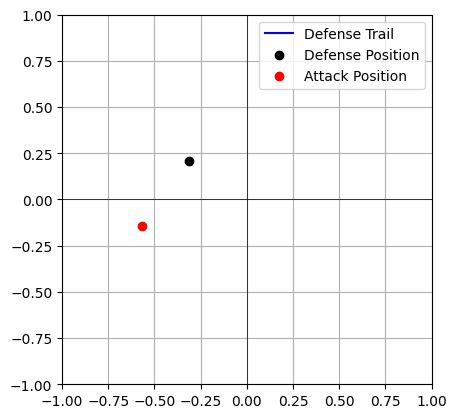

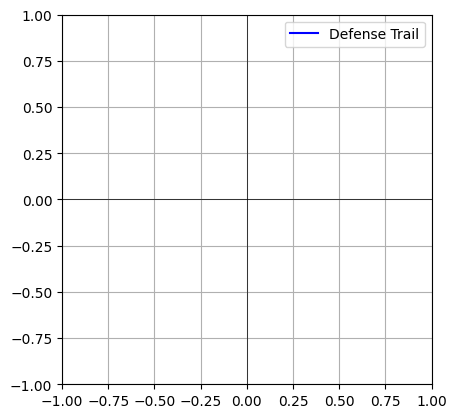

DEFENSE POSITIONS:  [array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182]), array([-0.31317359,  0.20903182])]
STEP REWARD:  1.4559159787008316
EPISODE REWARD:  -17.816864313022307


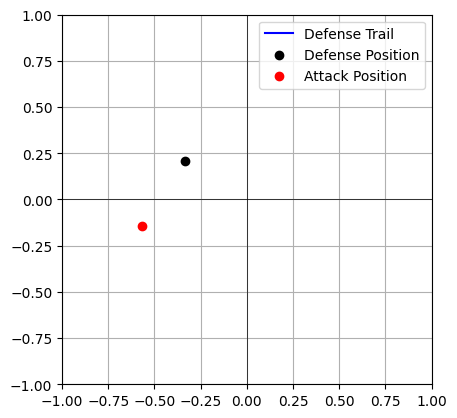

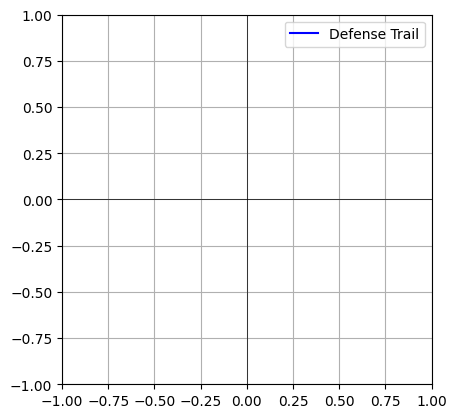

DEFENSE POSITIONS:  [array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096]), array([-0.33317359,  0.20903096])]
STEP REWARD:  1.8213225862651141
EPISODE REWARD:  -15.995541726757192


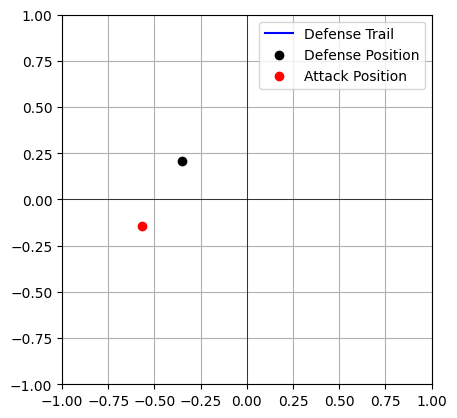

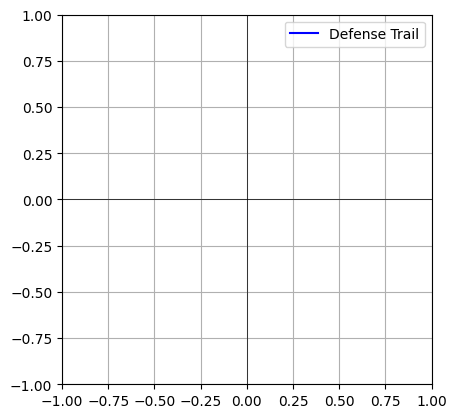

DEFENSE POSITIONS:  [array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716]), array([-0.3528696 ,  0.20555716])]
STEP REWARD:  2.195089558314542
EPISODE REWARD:  -13.80045216844265


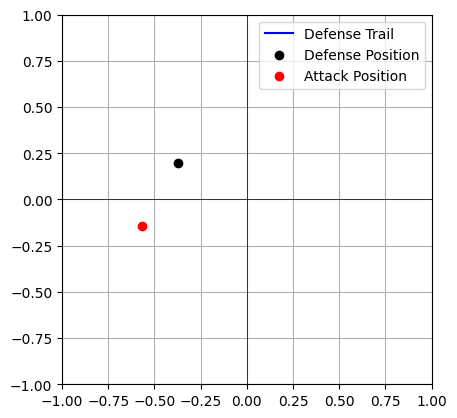

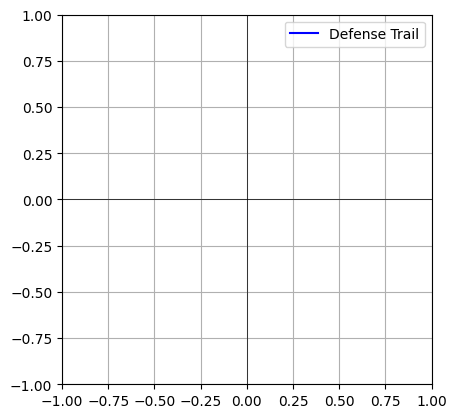

DEFENSE POSITIONS:  [array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595]), array([-0.37166316,  0.19871595])]
STEP REWARD:  2.6721085048828206
EPISODE REWARD:  -11.128343663559829


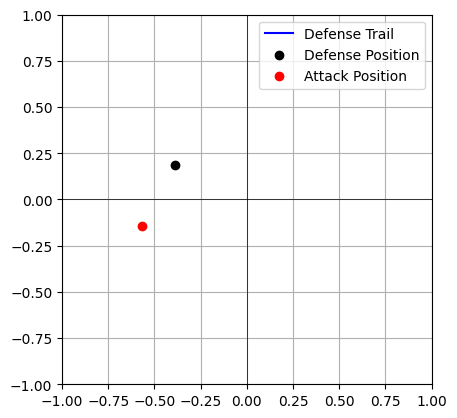

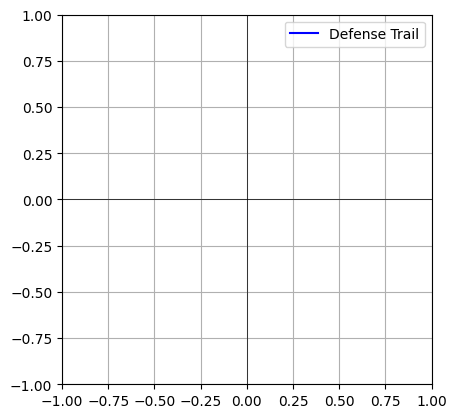

DEFENSE POSITIONS:  [array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521]), array([-0.38898324,  0.18871521])]
STEP REWARD:  2.915087489690985
EPISODE REWARD:  -8.213256173868844


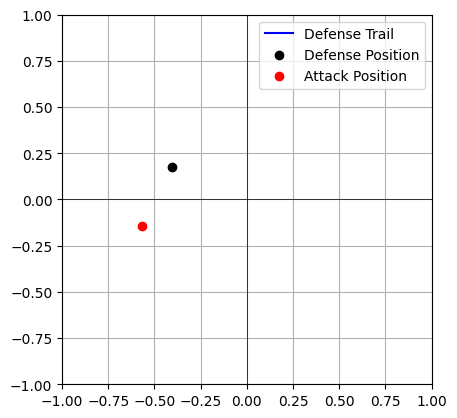

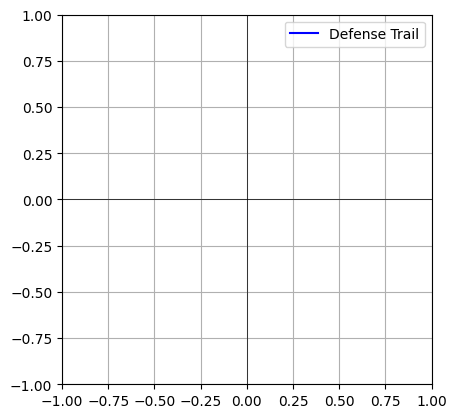

DEFENSE POSITIONS:  [array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881]), array([-0.40430358,  0.17585881])]
STEP REWARD:  3.2511834988510424
EPISODE REWARD:  -4.962072675017802


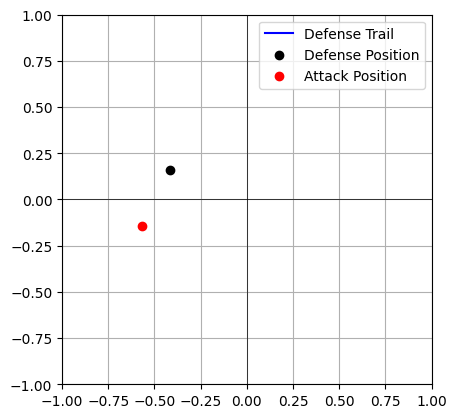

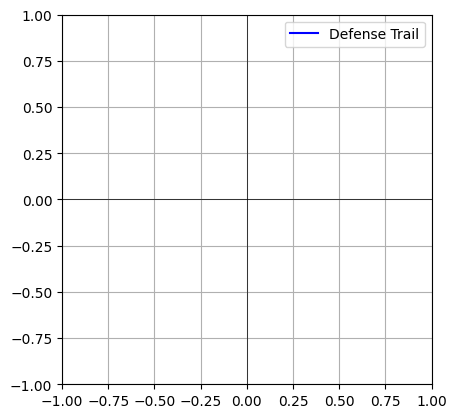

DEFENSE POSITIONS:  [array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737]), array([-0.41715868,  0.16053737])]
STEP REWARD:  3.558017599825043
EPISODE REWARD:  -1.4040550751927587


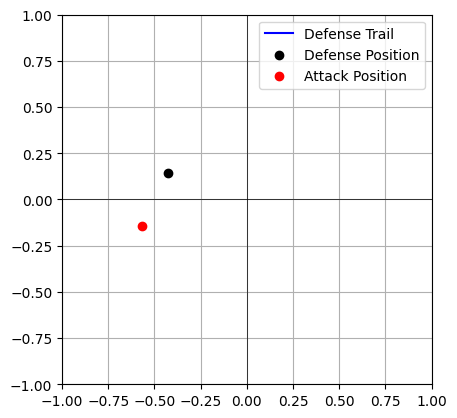

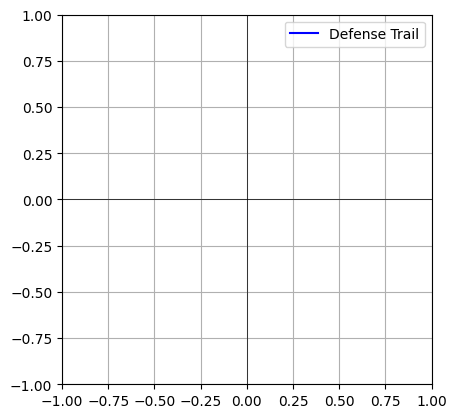

DEFENSE POSITIONS:  [array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643]), array([-0.42715794,  0.14321643])]
STEP REWARD:  3.802732961409813
EPISODE REWARD:  2.398677886217054


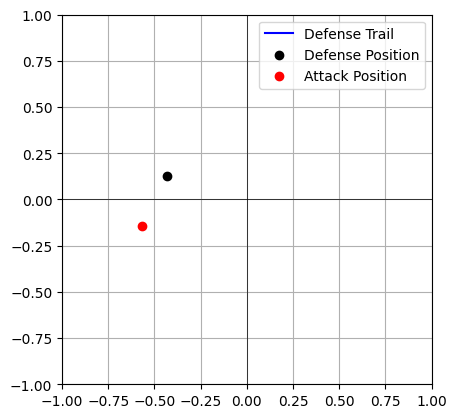

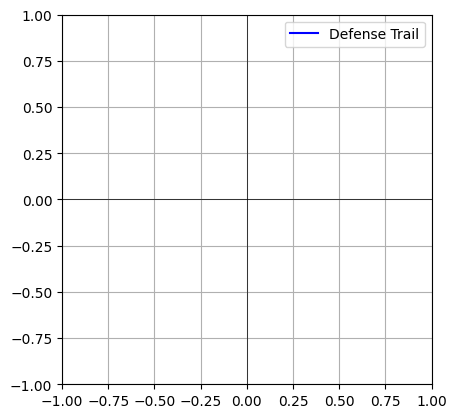

DEFENSE POSITIONS:  [array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229]), array([-0.43399754,  0.12442229])]
STEP REWARD:  3.9334363440709237
EPISODE REWARD:  6.332114230287978


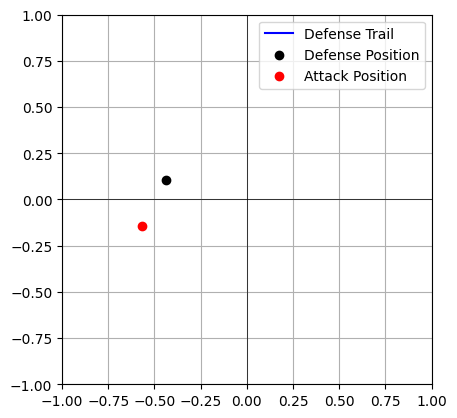

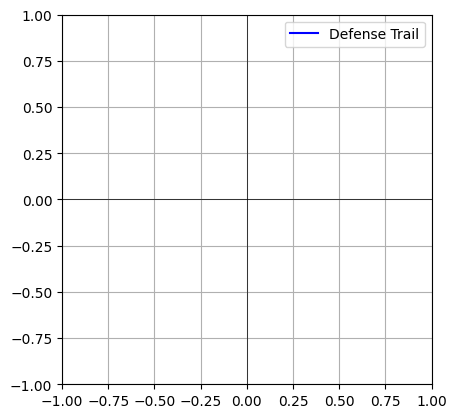

DEFENSE POSITIONS:  [array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598]), array([-0.43746966,  0.10472598])]
STEP REWARD:  4.474961034937153
EPISODE REWARD:  10.80707526522513


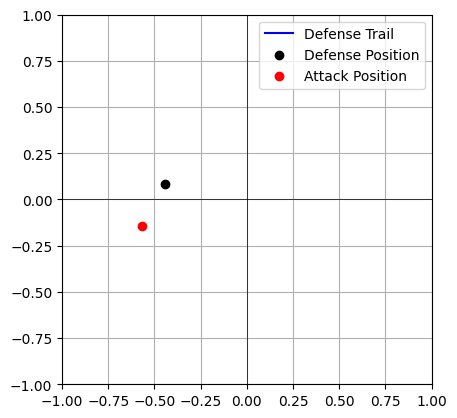

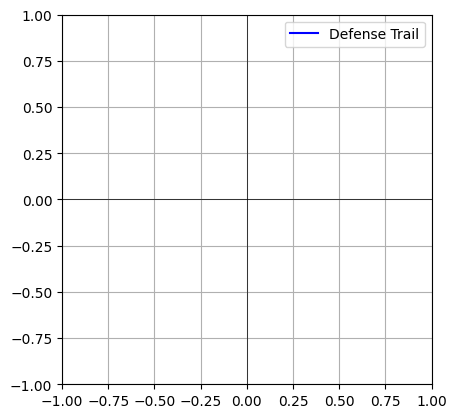

DEFENSE POSITIONS:  [array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184]), array([-0.44430926,  0.08593184])]
STEP REWARD:  4.659602841725017
EPISODE REWARD:  15.466678106950148


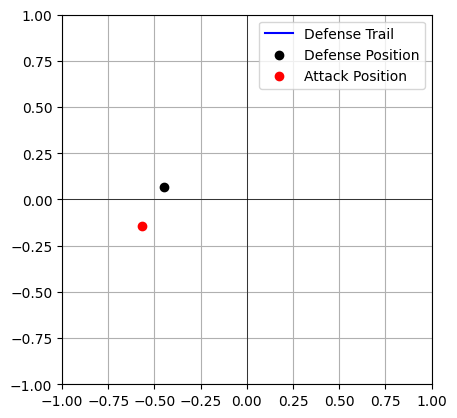

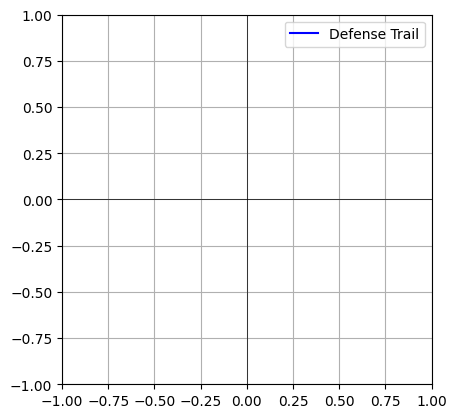

DEFENSE POSITIONS:  [array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554]), array([-0.44778138,  0.06623554])]
STEP REWARD:  5.414084302494639
EPISODE REWARD:  20.880762409444788


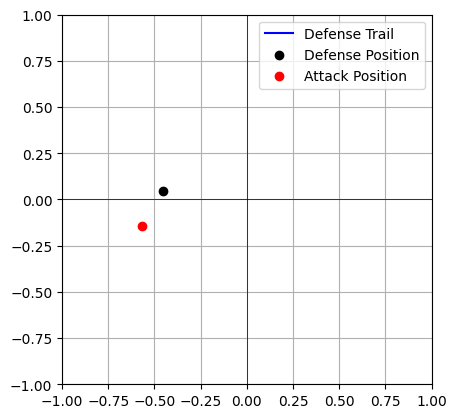

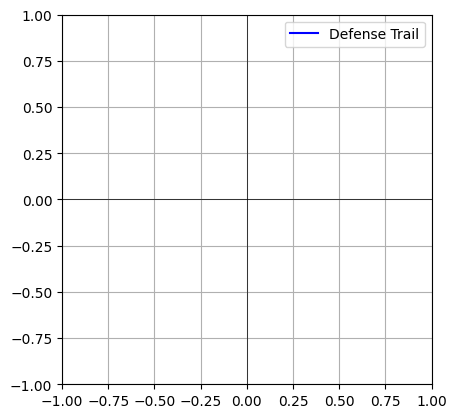

DEFENSE POSITIONS:  [array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139]), array([-0.45462098,  0.04744139])]
STEP REWARD:  5.684240071428896
EPISODE REWARD:  26.565002480873684


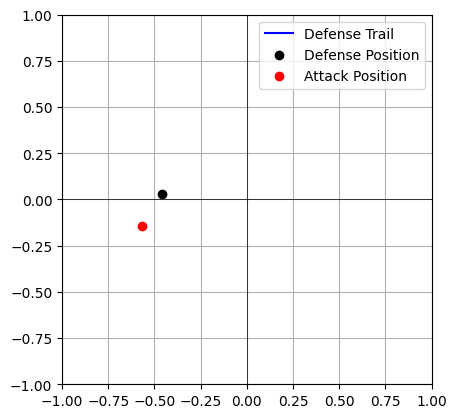

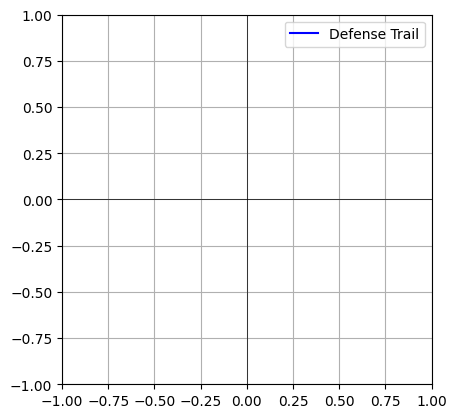

DEFENSE POSITIONS:  [array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509]), array([-0.4580931 ,  0.02774509])]
STEP REWARD:  5.601870360093781
EPISODE REWARD:  32.166872840967464


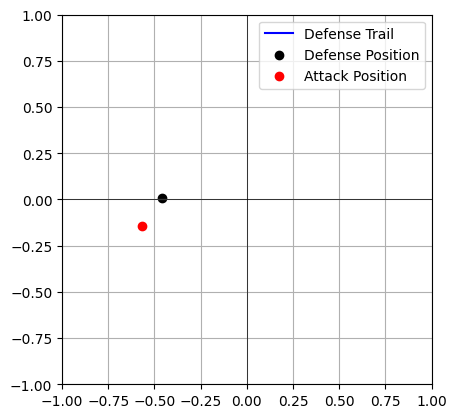

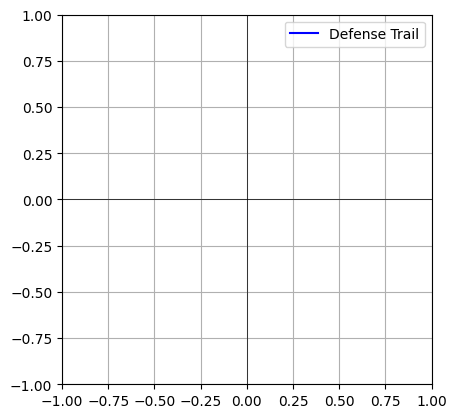

DEFENSE POSITIONS:  [array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509]), array([-0.45809225,  0.00774509])]
STEP REWARD:  6.8988170586344415
EPISODE REWARD:  39.06568989960191


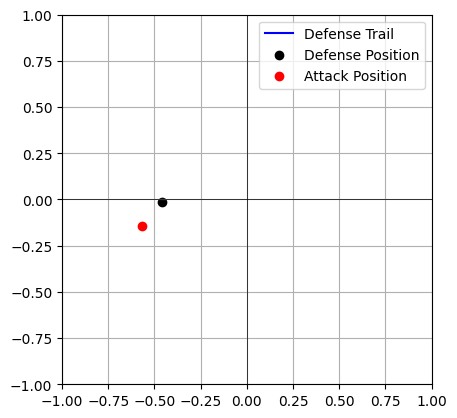

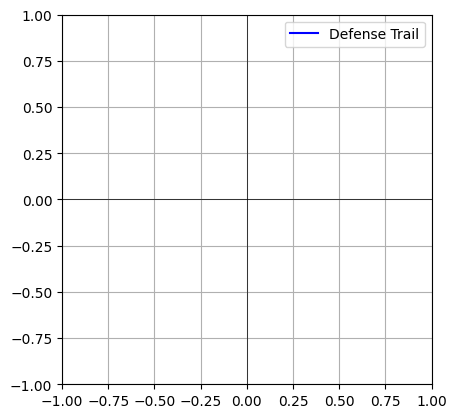

DEFENSE POSITIONS:  [array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122]), array([-0.46156437, -0.01195122])]
STEP REWARD:  6.584431469875316
EP

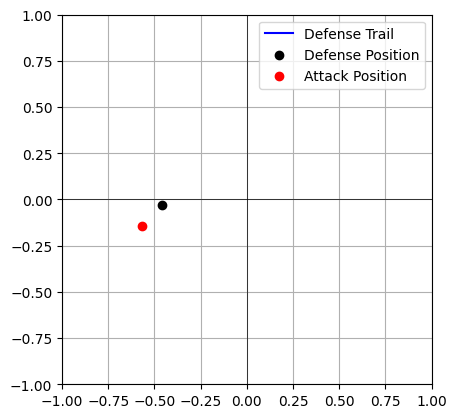

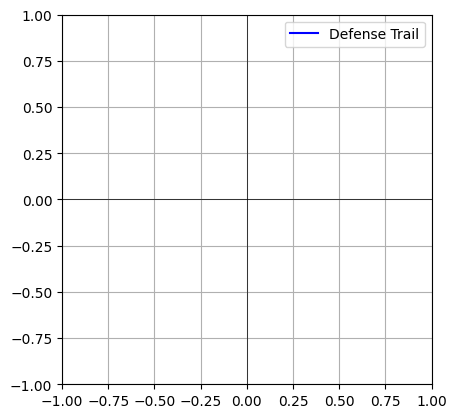

DEFENSE POSITIONS:  [array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122]), array([-0.46156351, -0.03195122])]

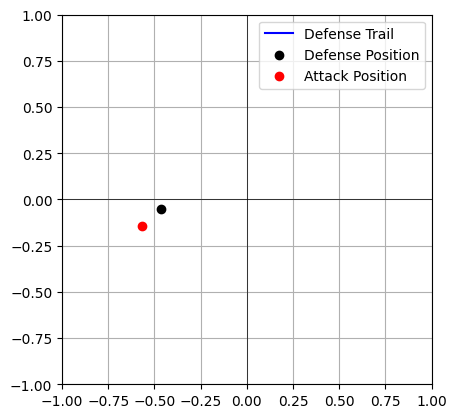

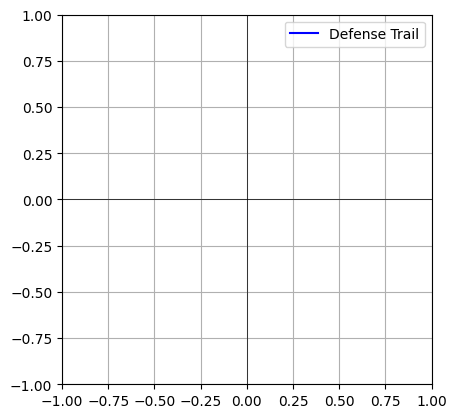

DEFENSE POSITIONS:  [array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]), array([-0.46503564, -0.05164752]),

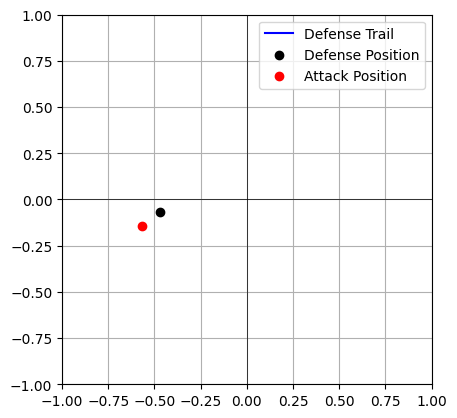

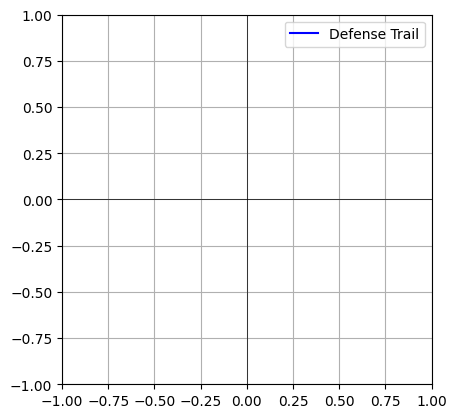

DEFENSE POSITIONS:  [array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]), array([-0.47187524, -0.07044166]),

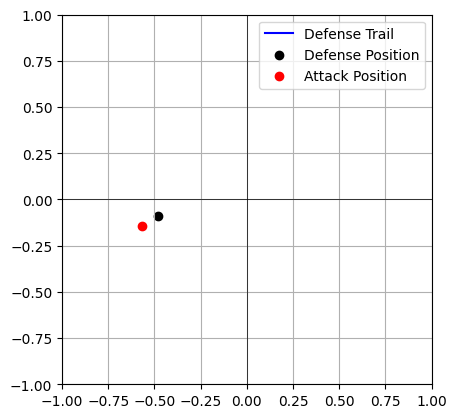

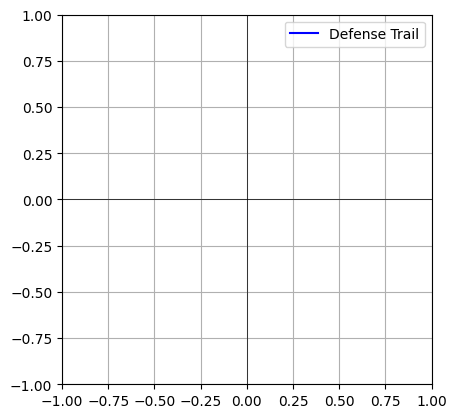

DEFENSE POSITIONS:  [array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.0877626]), array([-0.4818745, -0.

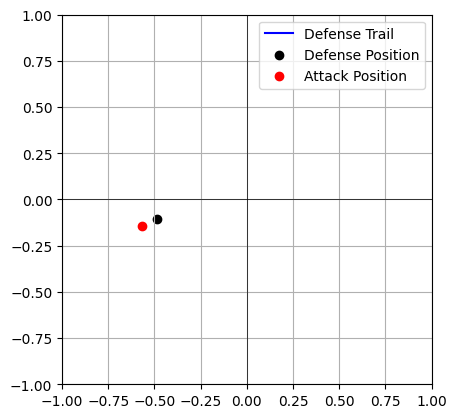

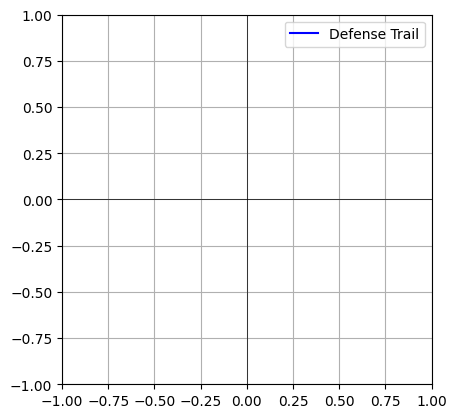

DEFENSE POSITIONS:  [array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]), array([-0.48871409, -0.10655674]),

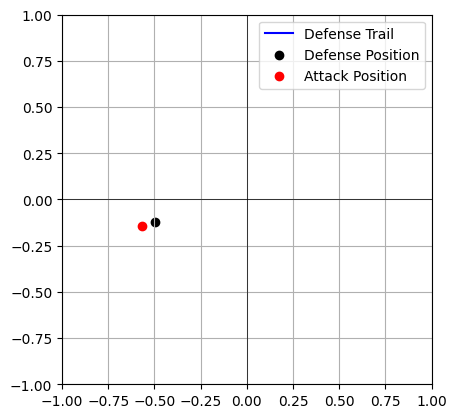

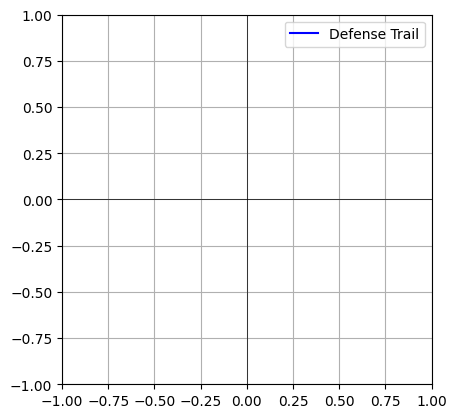

DEFENSE POSITIONS:  [array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]), array([-0.49871335, -0.12387768]),

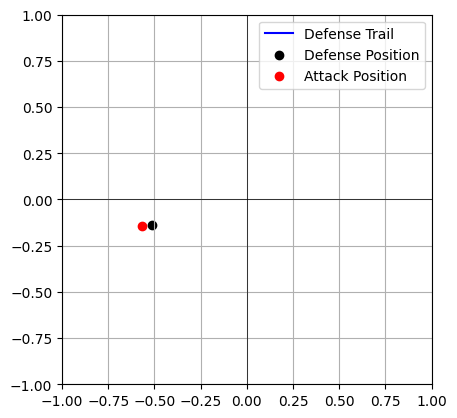

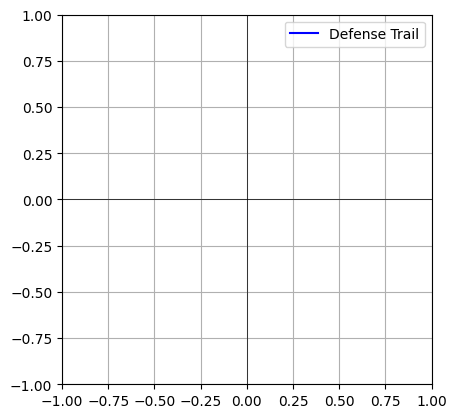

DEFENSE POSITIONS:  [array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]), array([-0.51156845, -0.13919912]),

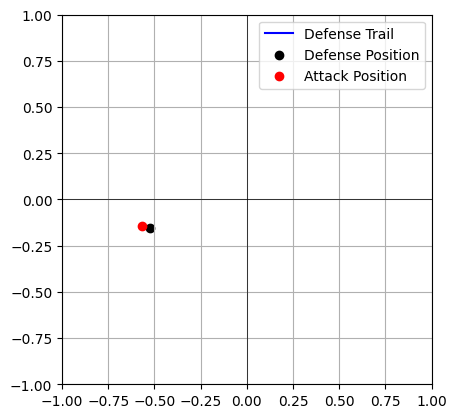

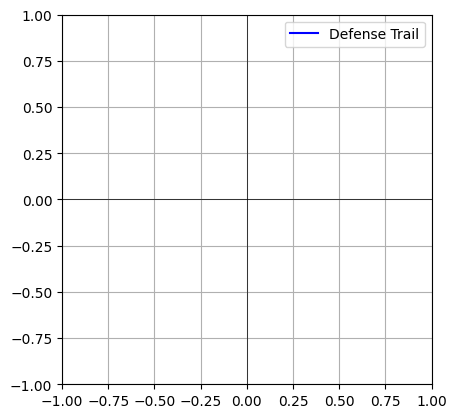

DEFENSE POSITIONS:  [array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]), array([-0.52688879, -0.15205553]),

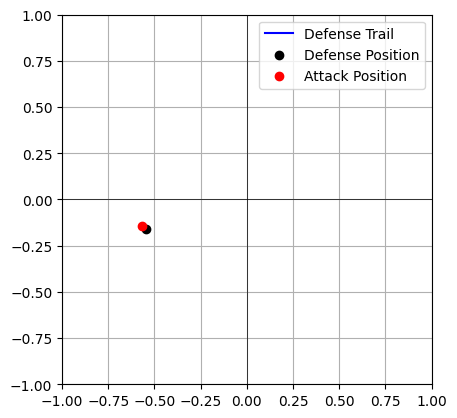

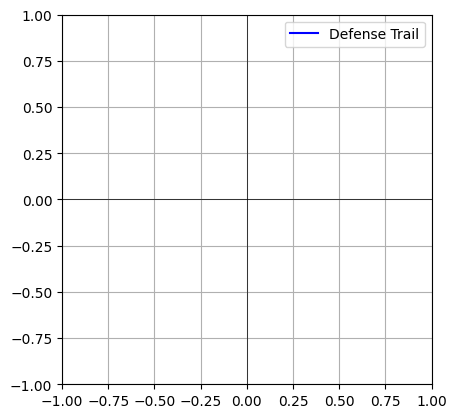

DEFENSE POSITIONS:  [array([ 0.15629737, -0.26073794])]
STEP REWARD:  -1.50139141119824
EPISODE REWARD:  -1.50139141119824


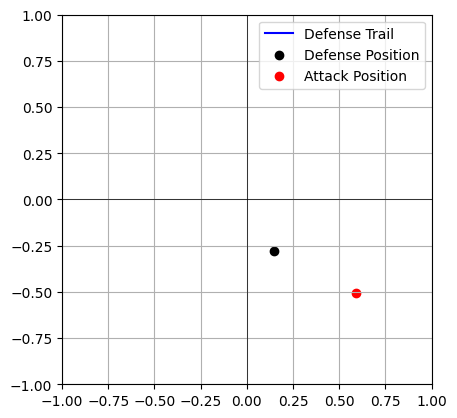

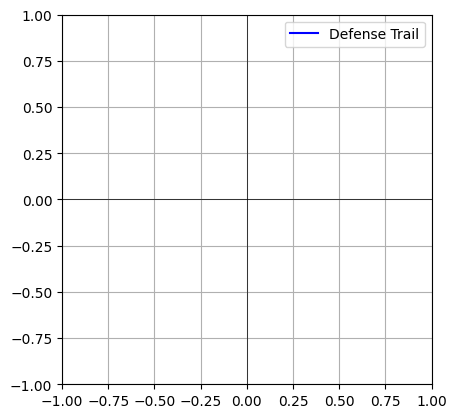

DEFENSE POSITIONS:  [array([ 0.14588973, -0.27781661]), array([ 0.14588973, -0.27781661])]
STEP REWARD:  0.03084594773770047
EPISODE REWARD:  -1.4705454634605395


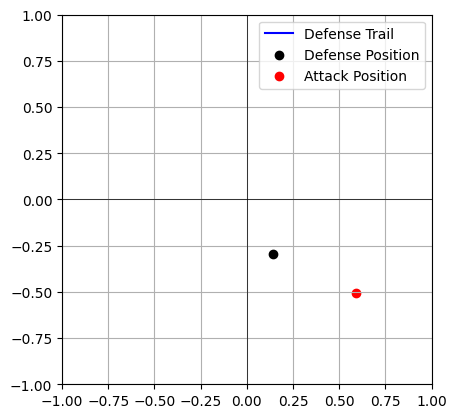

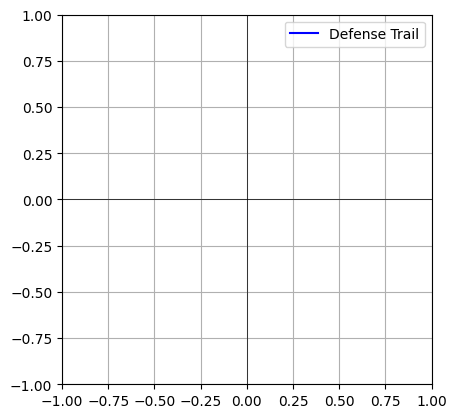

DEFENSE POSITIONS:  [array([ 0.13860588, -0.29644309]), array([ 0.13860588, -0.29644309]), array([ 0.13860588, -0.29644309])]
STEP REWARD:  0.3440258041592104
EPISODE REWARD:  -1.1265196593013291


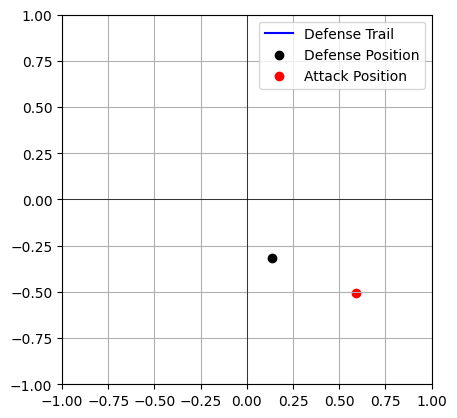

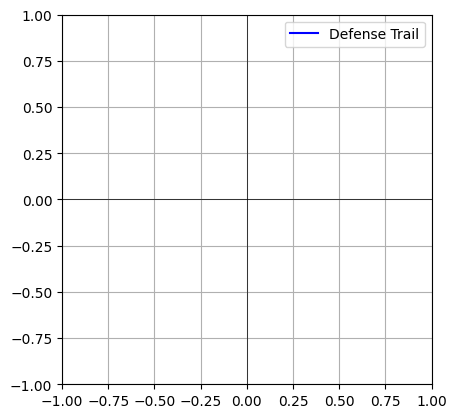

DEFENSE POSITIONS:  [array([ 0.13466714, -0.31605141]), array([ 0.13466714, -0.31605141]), array([ 0.13466714, -0.31605141]), array([ 0.13466714, -0.31605141])]
STEP REWARD:  0.6602733187987053
EPISODE REWARD:  -0.4662463405026238


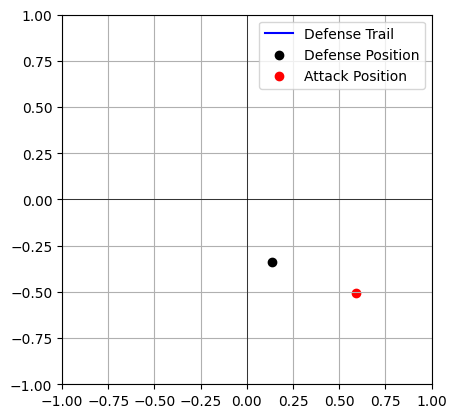

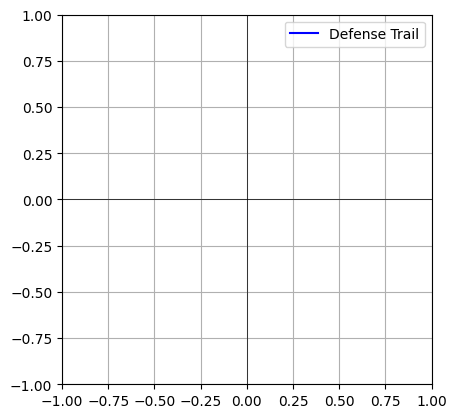

DEFENSE POSITIONS:  [array([ 0.13419319, -0.33604579]), array([ 0.13419319, -0.33604579]), array([ 0.13419319, -0.33604579]), array([ 0.13419319, -0.33604579]), array([ 0.13419319, -0.33604579])]
STEP REWARD:  0.9801876163026859
EPISODE REWARD:  0.5139412758000621


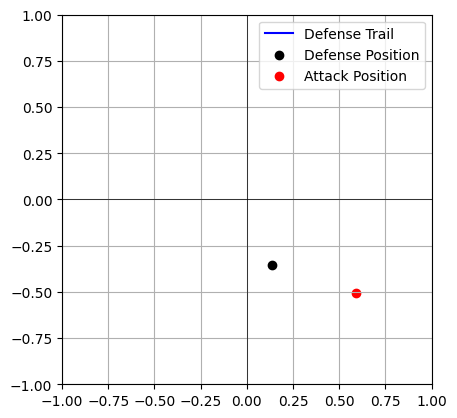

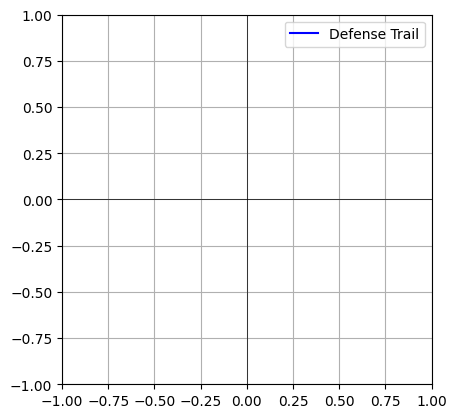

DEFENSE POSITIONS:  [array([ 0.13719843, -0.35581872]), array([ 0.13719843, -0.35581872]), array([ 0.13719843, -0.35581872]), array([ 0.13719843, -0.35581872]), array([ 0.13719843, -0.35581872]), array([ 0.13719843, -0.35581872])]
STEP REWARD:  1.3039106459758472
EPISODE REWARD:  1.8178519217759093


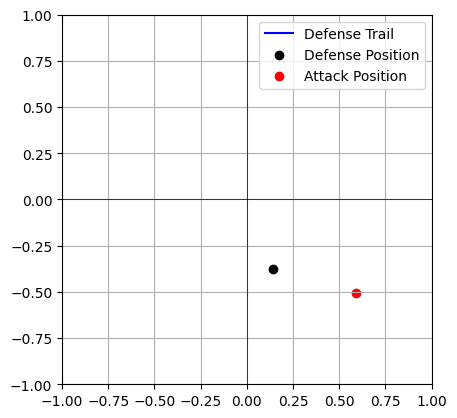

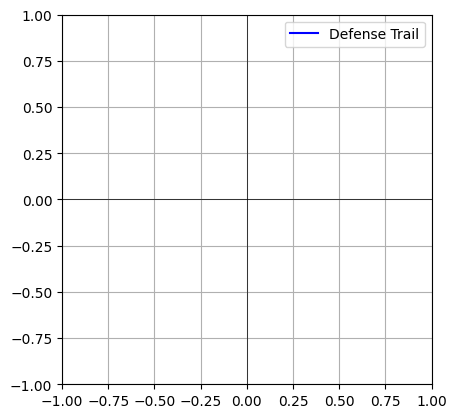

DEFENSE POSITIONS:  [array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939]), array([ 0.14359154, -0.37476939])]
STEP REWARD:  1.6307931917435305
EPISODE REWARD:  3.44864511351944


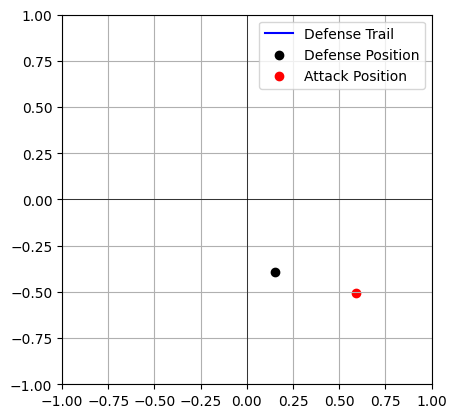

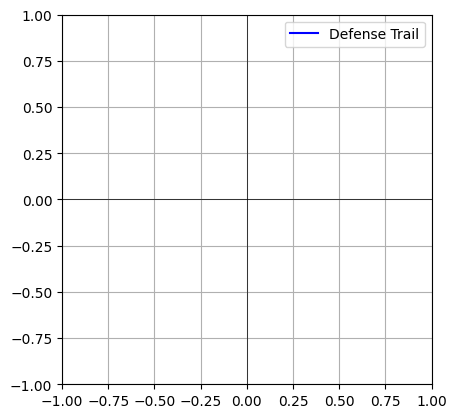

DEFENSE POSITIONS:  [array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201]), array([ 0.15317828, -0.39232201])]
STEP REWARD:  1.95888608760928
EPISODE REWARD:  5.4075312011287195


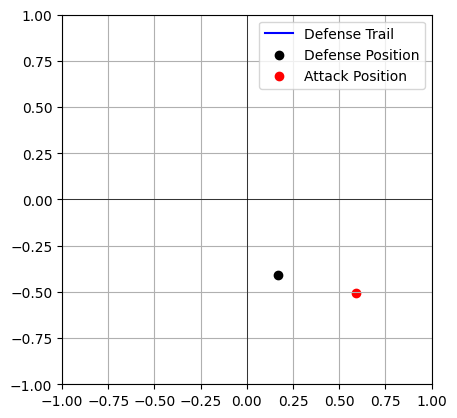

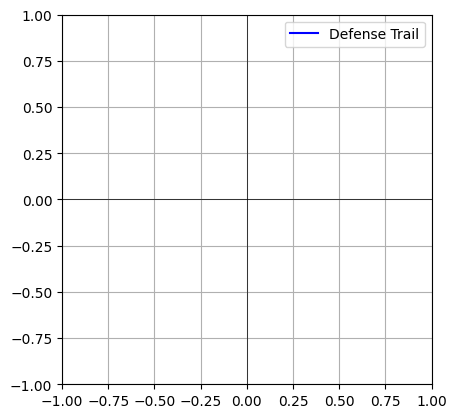

DEFENSE POSITIONS:  [array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325]), array([ 0.16566736, -0.40794325])]
STEP REWARD:  2.2841632924244797
EPISODE REWARD:  7.691694493553199


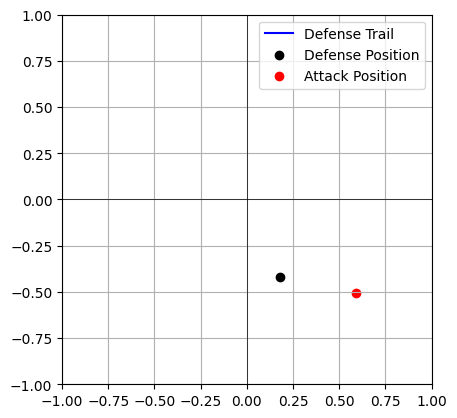

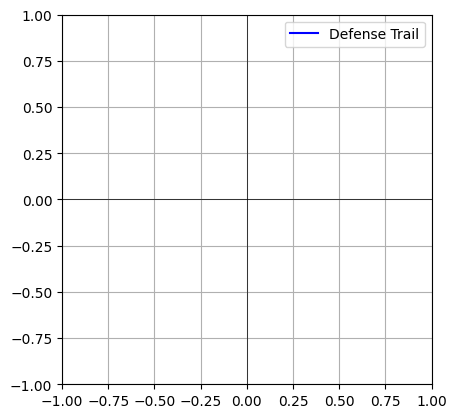

DEFENSE POSITIONS:  [array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846]), array([ 0.18067929, -0.42115846])]
STEP REWARD:  2.702858290846469
EPISODE REWARD:  10.394552784399668


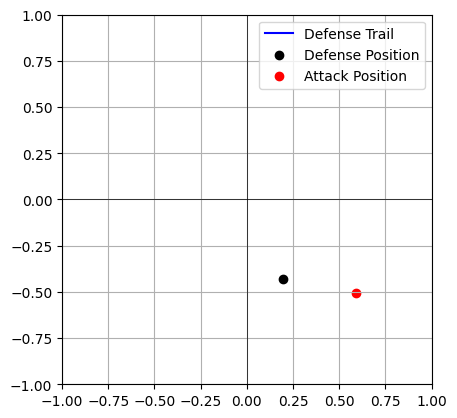

KeyboardInterrupt: 

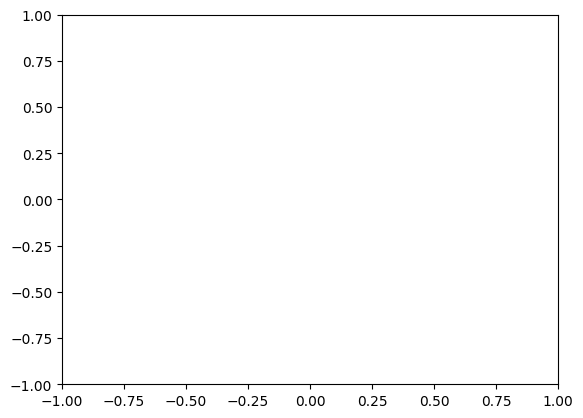

In [46]:
import time

model = DQN.load("dqn_missile_interception")


eval_env = missile_interception()

def graph(defense_positions, defense, attack):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    defense_xs, defense_ys = zip(*defense_positions)
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  
    ax.scatter(defense[0], defense[1], color='black', label='Defense Position')
    ax.scatter(attack[0], attack[1], color='red', label='Attack Position')

    ax.set_aspect('equal')
    ax.legend()
    plt.show()

def just_trails(defense_positions):
    fig, ax = plt.subplots()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    # Extracting x and y coordinates
    defense_xs, defense_ys = zip(*defense_positions)
    ax.plot(defense_xs, defense_ys, 'b-', label='Defense Trail')  # Blue line for defense trail

    ax.set_aspect('equal')
    ax.legend()
    plt.show()


# Number of evaluation episodes
n_eval_episodes = 10

# Lists to store results
episode_rewards = []
episode_lengths = []
interceptions = 0
out_of_bounds = 0
reached_max_steps = 0

for i in range(n_eval_episodes):
    obs, _ = eval_env.reset()
    done = False
    episode_reward = 0
    episode_length = 0
    defense_positions = []  # Store defense positions for plotting

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        defense_positions.append(eval_env.defense)
        print("DEFENSE POSITIONS: ", defense_positions)
        obs, reward, done, _, info = eval_env.step(action)
        episode_reward += reward
        print("STEP REWARD: ", reward)
        print("EPISODE REWARD: ", episode_reward)
        episode_length += 1

        # Update stats based on info dictionary if needed
        # interceptions += info.get('interceptions', 0)
        # out_of_bounds += info.get('out_of_bounds', 0)
        # reached_max_steps += info.get('reached_max_steps', 0)

        # Graph current and trail positions
        graph(defense_positions, eval_env.defense, eval_env.attack)
        just_trails(defense_positions)

    # Store results
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

# Output averaged results or other statistics
print(f"Average Reward: {sum(episode_rewards) / len(episode_rewards)}")
print(f"Average Episode Length: {sum(episode_lengths) / len(episode_lengths)}")




# def graph(trajectory_data):
#     fig, ax = plt.subplots()
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(0, color='black', linewidth=0.5)
#     plt.grid(True)

#     # Plot trajectories
#     for trail in trajectory_data:
#         defense_xs, defense_ys = zip(*trail['defense_positions'])
#         attack_xs, attack_ys = zip(*trail['attack_positions'])
#         ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense
#         ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack
#         plt.scatter(defense_xs[-1], defense_ys[-1], color='black')  # Current defense position
#         plt.scatter(attack_xs[-1], attack_ys[-1], color='red')  # Current attack position

#     plt.show()

# for i in range(n_eval_episodes):
#     obs, _ = eval_env.reset()
#     done = False
#     episode_reward = 0
#     episode_length = 0
#     trajectories = {'defense_positions': [], 'attack_positions': []}  # Store trajectories
    
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, _, info = eval_env.step(action)
#         env.graph(eval_env.defense, eval_env.attack)
#         trajectories['defense_positions'].append(tuple(eval_env.defense))
#         trajectories['attack_positions'].append(tuple(eval_env.attack))
#         episode_reward += reward
#         episode_length += 1
        
    
#     episode_rewards.append(episode_reward)
#     episode_lengths.append(episode_length)
#     interceptions += eval_env.interceptions
#     out_of_bounds += eval_env.out_of_bounds
#     reached_max_steps += eval_env.reached_max_steps
#     graph(trajectories)

# # Calculate average metrics
# avg_reward = np.mean(episode_rewards)
# avg_length = np.mean(episode_lengths)
# success_rate = interceptions / n_eval_episodes
# out_of_bounds_rate = out_of_bounds / n_eval_episodes
# max_steps_rate = reached_max_steps / n_eval_episodes

# print(f"Average Reward: {avg_reward:.2f}")
# print(f"Average Episode Length: {avg_length:.2f}")
# print(f"Success Rate: {success_rate:.2%}")
# print(f"Out of Bounds Rate: {out_of_bounds_rate:.2%}")
# print(f"Reached Max Steps Rate: {max_steps_rate:.2%}")

In [ ]:
# import gymnasium as gym
# from stable_baselines3 import DQN, PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# env = DummyVecEnv([lambda: missile_interception()])

# summary_writer = tf.summary.create_file_writer('./dqn_missile_interception_logs')

# def run_episode(env):
#     with summary_writer.as_default():
#         for step in range(env.max_steps):
#             ...
#             tf.summary.scalar('Reward', reward, step=total_steps)
#             if done:
#                 tf.summary.scalar('Episode Length', step + 1, step=episode)
#                 break
#         tf.summary.scalar('Out of Bounds Count', env.out_of_bounds, step=episode)
#         tf.summary.scalar('Interceptions Count', env.interceptions, step=episode)
#         tf.summary.scalar('Reached Max Steps Count', env.reached_max_steps, step=episode)

# model = DQN("MlpPolicy", env, tensorboard_log="./dqn_missile_interception_logs", verbose=1)
# model.learn(total_timesteps=1000000)
# model.save("updated_missile_guidance")
# env.close()

In [ ]:
# # import gymnasium as gym
# import numpy as np
# import matplotlib.pyplot as plt
# import random
# import math
# import tensorflow as tf
# import datetime

# # Assuming missile_interception is already defined and imported

# def run_episodes(num_episodes, max_steps_per_episode):
#     # Initialize variables for tracking statistics
#     episode_lengths = []
#     hits = 0  # Track the number of successful hits

#     # Run multiple episodes
#     for episode in range(num_episodes):
#         # Reset the environment at the start of each episode
#         env = missile_interception()
#         _, _ = env.reset()
        
#         print("----------------------------------------------------------")
#         print(f"STARTING EPISODE {episode + 1}")
#         print("----------------------------------------------------------")
        
#         # Run the simulation for up to max_steps_per_episode or until the episode ends
#         for step in range(max_steps_per_episode):
#             # Choose a random action
#             action = random.choice([0, 1, 2])
#             # actions = [random.choice([0, 1, 2]) for _ in range(num_steps)]
            
#             # Take the action and observe the outcome
#             state, reward, done, truncated, _ = env.step(action)

#             # Check if a hit has occurred, typically by checking reward or state
#             if reward > 90:  # Assuming reward > 90 indicates a hit
#                 hits += 1
#                 print(f"Hit! Missile successfully intercepted the target at step {step + 1} of episode {episode + 1}.")

#             if done:
#                 # If the episode has ended, record the length
#                 episode_lengths.append(step + 1)
#                 print(f"Episode {episode + 1} ended after {step + 1} steps.")
#                 break
#         else:
#             # If not done after max steps, consider it a full length episode
#             episode_lengths.append(max_steps_per_episode)
    
#     # Calculate the average episode length
#     average_length = np.mean(episode_lengths)
#     return average_length, episode_lengths, hits

# # Parameters
# num_episodes = 100
# max_steps_per_episode = 150

# # Run the simulations
# average_length, episode_lengths, total_hits = run_episodes(num_episodes, max_steps_per_episode)

# print("----------------------------------------------------------")
# print(f"Average episode length over {num_episodes} episodes: {average_length:.2f} steps")
# print(f"Total hits across all episodes: {total_hits}")
# print("----------------------------------------------------------")
